# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


Le projet a été préparé par Gabriel Gobeil, associé de recherche à Polytechnique Montréal.

---
# Projet A2022 : Récolte des cerfs de Virginie


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/23b6d8c44f1247c78e19a6a902f804af

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- recolte.csv
- permis.csv
- meteo.csv
- essence.csv
- test.csv

**Déposez ces fichiers dans un dossier nommé *data* dans le répertoire de ce calepin.**

Le fichier *recolte.csv* contient les statistiques de chasse au cerf de Viriginie. On y retrouve le nombre de cerfs mâles adultes récoltés annuellement dans certaines zones de chasse du Québec, listé selon le type d'engin utilisé.

Le fichier *permis.csv* contient des informations sur le nombre de permis de chasse aux cerfs de Virginie alloués aux résidents et non-résidents de 1999 à 2020.

Le fichier *meteo.csv* contient certaines variables météorologiques enregistrées à la station Montréal-Trudeau de 1999 à 2021 :
- Mean Temp (°C)	
- Total Rain (mm)	
- Total Snow (cm)	
- Snow on Grnd (cm)

Le fichier *essence.csv* contient des informations sur le prix de détail moyen par mois de l'essence pour Québec et Montréal de 1999 à 2021. Des renseignements additionnels sur les données sont disponibles à l'adresse suivante : https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=1810000101

Le fichier *test.csv* contient les zones de chasse pour lesquels vous devez prédire le nombre de cerfs mâles adultes récoltés pour l'année 2021, peu importe l'engin de chasse utilisé. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est suffisante.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

#### Travail effectué par:


Chatelier, Fedwin, 2104132 

Aumais-Boucher, Etienne, 2086773

Thibodeau, Zachary, 2083781 

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Distributions, LinearAlgebra, GLM, Combinatorics, StatsBase, Random

---
## 1. Chargement de données

#### Récolte annuelle de cerfs par zones de chasse selon les différents engins

In [2]:
recolte = CSV.read("data/recolte.csv", DataFrame)
first(recolte, 5)

,Année,Zone,Engin,Cerfs
,Int64,Int64,String15,Int64
1,1999,2,Arc,58
2,1999,2,Carabine,852
3,1999,2,Indéterminé,12
4,1999,3,Arc,94
5,1999,3,Carabine,1422


#### Nombre de permis de chasse alloués annuellement aux résidents et non-résidents

In [3]:
permis = CSV.read("data/permis.csv", DataFrame)
n = size(permis,1)
for i in range(1, n)
    residents_premier_abbatage = permis[i, :"Résidents premier abbatage"]
    if (ismissing(residents_premier_abbatage))
        permis[i, :"Résidents premier abbatage"] = 0
    end
end

permis.Total = [permis[i, :Résidents] + permis[i, :"Résidents premier abbatage"] + permis[i, :"Non-résidents"] for i in 1:n]
first(permis, 5)

,Année,Résidents,Résidents premier abbatage,Non-résidents,Total
,Int64,Int64?,Int64?,Int64?,Int64?
1,1998,135409,0,1230,136639
2,1999,131325,0,1260,132585
3,2000,137346,0,1463,138809
4,2001,144074,0,1551,145625
5,2002,151154,0,1735,152889


#### Moyenne mensuelle du prix de détail de l'essence en cents pour Québec et Montréal

In [4]:
essence = CSV.read("data/essence.csv", DataFrame)
first(essence, 5)

,Mois,Québec,Montréal
,Date,Float64,Float64
1,1997-04-01,60.1,60.3
2,1997-05-01,60.7,60.5
3,1997-06-01,59.4,61.5
4,1997-07-01,57.9,59.7
5,1997-08-01,62.8,64.0


#### Données météorologiques quotidiennes à Montréal-Trudeau entre 1999 et 2021

In [5]:
meteo = CSV.read("data/meteo.csv", DataFrame)
n = size(meteo,1)
meteo.Année = [Dates.year(meteo[i, :"Date/Time"]) for i in 1:n]

first(meteo, 5)

,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Snow on Grnd (cm)
,Date,Float64?,Float64?,Float64?,Int64?
1,1999-01-01,-20.5,0.0,1.0,2
2,1999-01-02,-19.2,0.0,0.0,2
3,1999-01-03,-8.5,1.2,11.4,7
4,1999-01-04,-9.4,0.0,0.0,8
5,1999-01-05,-14.3,0.0,0.0,8


#### Construction du tableau des variables transformée en données anuelles
Sachant que la période de chasse est qu'en automne de chaque année, nous pensons que seule les données de météo et du prix de l'essence durant cette période sera pertinente pour notre analyse des variables ainsi que nos prédictions.

##### Température moyenne annuelle

In [6]:
Temp = CSV.read("data/meteo.csv", DataFrame)
# On remplace les données manquantes par 0
  n = length(Temp[!, "Mean Temp (°C)"])
    for i = 1:n
        Temp[!, "Mean Temp (°C)"][i] = Temp[!, "Mean Temp (°C)"][i] !== missing ?  Temp[!, "Mean Temp (°C)"][i] : 0.0
    end

rename!(Temp, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 
#sélection des donnée de l'automne, donc de septembre à novembre de chaque années
Temp = Temp[[10 <= Dates.month(Temp.Année[i]) <= 11 for i in 1:length(Temp.Année)], :]

Temp[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Temp[!,"Année"]] #Utilisation de l'année seulement
TempMoy = DataFrame(Année = Int64[], Temp = Float64[])
TempMoy = combine(groupby(Temp, :Année), :"Mean Temp (°C)" => mean∘skipmissing => :"Température")
push!(TempMoy, [2013, 0.0])
Temp2021 = TempMoy.Température[22]
TempMoy

,Année,Température
,Int64,Float64
1,1999,6.36721
2,2000,5.81311
3,2001,7.59836
4,2002,3.94262
5,2003,5.47705
6,2004,5.64098
7,2005,6.53934
8,2006,6.19508
9,2007,6.28689


##### Pluie totale annuelle

In [7]:
Pluie = CSV.read("data/meteo.csv", DataFrame)
rename!(Pluie, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
Pluie = Pluie[[10 <= Dates.month(Pluie.Année[i]) <= 11 for i in 1:length(Pluie.Année)], :]

Pluie[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Pluie[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(Pluie[!, "Total Rain (mm)"])
    for i = 1:n
        Pluie[!, "Total Rain (mm)"][i] = Pluie[!, "Total Rain (mm)"][i] !== missing ?  Pluie[!, "Total Rain (mm)"][i] : 0.0
    end
PluieAn = combine(groupby(Pluie, :Année), :"Total Rain (mm)" => sum => :"Pluie_totale")
push!(PluieAn, [2013, 0.0])

,Année,Pluie_totale
,Int64,Float64
1,1999,139.7
2,2000,79.9
3,2001,155.9
4,2002,108.9
5,2003,287.4
6,2004,122.6
7,2005,279.8
8,2006,250.8
9,2007,162.0


##### Neige total tombée annuelle

In [8]:
Neige = CSV.read("data/meteo.csv", DataFrame)
rename!(Neige, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
Neige = Neige[[10 <= Dates.month(Neige.Année[i]) <= 11 for i in 1:length(Neige.Année)], :]

Neige[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Neige[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(Neige[!, "Total Snow (cm)"])
    for i = 1:n
        Neige[!, "Total Snow (cm)"][i] = Neige[!, "Total Snow (cm)"][i] !== missing ?  Neige[!, "Total Snow (cm)"][i] : 0.0
    end
NeigeAn = combine(groupby(Neige, :Année), :"Total Snow (cm)" => sum => :"Neige_totale")
push!(NeigeAn, [2013, 0.0])

,Année,Neige_totale
,Int64,Float64
1,1999,5.1
2,2000,9.6
3,2001,4.6
4,2002,63.3
5,2003,2.8
6,2004,0.4
7,2005,13.6
8,2006,0.0
9,2007,29.0


#### Neige totale sur le sol annuelle

In [9]:
NeigeSol = CSV.read("data/meteo.csv", DataFrame)
rename!(NeigeSol, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
NeigeSol = NeigeSol[[10 <= Dates.month(NeigeSol.Année[i]) <= 11 for i in 1:length(NeigeSol.Année)], :]

NeigeSol[!,"Année"] = [item == item ? Dates.year(item) : "" for item in NeigeSol[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(NeigeSol[!, "Snow on Grnd (cm)"])
    for i = 1:n
        NeigeSol[!, "Snow on Grnd (cm)"][i] = NeigeSol[!, "Snow on Grnd (cm)"][i] !== missing ?  NeigeSol[!, "Snow on Grnd (cm)"][i] : 0.0
    end
NeigeSolAn = combine(groupby(NeigeSol, :Année), :"Snow on Grnd (cm)" => sum => :"Neige_totale_au_sol")
push!(NeigeSolAn, [2013, 0.0])

,Année,Neige_totale_au_sol
,Int64,Int64
1,1999,2
2,2000,13
3,2001,2
4,2002,68
5,2003,1
6,2004,0
7,2005,20
8,2006,0
9,2007,52


#### Nombre de jours ayant de la neige au sol dans l'année

Nous ajoutons les variables transformée du nombre de jours ayant un certain évènements, car nous pensons que cela pourrait avoir un impact sur le nombre de cerfs récoltés. Nous validerons cela dans notre analyse exploratoire.

In [10]:
JourNeigeSol = CSV.read("data/meteo.csv", DataFrame)
rename!(JourNeigeSol, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourNeigeSol = JourNeigeSol[[10 <= Dates.month(JourNeigeSol.Année[i]) <= 11 for i in 1:length(JourNeigeSol.Année)], :]

JourNeigeSol[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourNeigeSol[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la neige au sol 
    n = length(JourNeigeSol[!, "Snow on Grnd (cm)"])
    for i = 1:n
        JourNeigeSol[!, "Snow on Grnd (cm)"][i] = JourNeigeSol[!, "Snow on Grnd (cm)"][i] !== missing ?  JourNeigeSol[!, "Snow on Grnd (cm)"][i] : 0
        JourNeigeSol[!, "Snow on Grnd (cm)"][i] = JourNeigeSol[!, "Snow on Grnd (cm)"][i] !== 0 ?  1 : 0
    end
JourNeigeSolAn = combine(groupby(JourNeigeSol, :Année), :"Snow on Grnd (cm)" => sum => :"Jours_neige_au_sol")
push!(JourNeigeSolAn, [2013, 0.0])

,Année,Jours_neige_au_sol
,Int64,Int64
1,1999,1
2,2000,5
3,2001,1
4,2002,14
5,2003,1
6,2004,0
7,2005,6
8,2006,0
9,2007,9


#### Nombre de jours où il a plu dans l'année

In [11]:
JourPluie = CSV.read("data/meteo.csv", DataFrame)
rename!(JourPluie, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourPluie = JourPluie[[10 <= Dates.month(JourPluie.Année[i]) <= 11 for i in 1:length(JourPluie.Année)], :]

JourPluie[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourPluie[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la pluie 
    n = length(JourPluie[!, "Total Rain (mm)"])
    for i = 1:n
        JourPluie[!, "Total Rain (mm)"][i] = JourPluie[!, "Total Rain (mm)"][i] !== missing ?  JourPluie[!, "Total Rain (mm)"][i] : 0
        JourPluie[!, "Total Rain (mm)"][i] = JourPluie[!, "Total Rain (mm)"][i] !== 0.0 ?  1.0 : 0.0
    end
JourPluieAn = combine(groupby(JourPluie, :Année), :"Total Rain (mm)" => sum => :"Jours_de_pluie")
push!(JourPluieAn, [2013, 0.0])

,Année,Jours_de_pluie
,Int64,Float64
1,1999,26.0
2,2000,19.0
3,2001,33.0
4,2002,22.0
5,2003,25.0
6,2004,20.0
7,2005,31.0
8,2006,33.0
9,2007,24.0


#### Nombre de jours où il a neigé dans l'année

In [12]:
JourNeige = CSV.read("data/meteo.csv", DataFrame)
rename!(JourNeige, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourNeige = JourNeige[[10 <= Dates.month(JourNeige.Année[i]) <= 11 for i in 1:length(JourNeige.Année)], :]

JourNeige[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourNeige[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la neige 
    n = length(JourNeige[!, "Total Snow (cm)"])
    for i = 1:n
        JourNeige[!, "Total Snow (cm)"][i] = JourNeige[!, "Total Snow (cm)"][i] !== missing ?  JourNeige[!, "Total Snow (cm)"][i] : 0
        JourNeige[!, "Total Snow (cm)"][i] = JourNeige[!, "Total Snow (cm)"][i] !== 0.0 ?  1.0 : 0.0
    end
JourNeigeAn = combine(groupby(JourNeige, :Année), :"Total Snow (cm)" => sum => :"Jours_de_neige")
push!(JourNeigeAn, [2013, 0.0])

,Année,Jours_de_neige
,Int64,Float64
1,1999,3.0
2,2000,7.0
3,2001,1.0
4,2002,14.0
5,2003,3.0
6,2004,1.0
7,2005,7.0
8,2006,0.0
9,2007,8.0


#### Prix moyen de l'essence annuelle à Montréal

In [13]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceMtlMoyAn = DataFrame(Année = essence.Année, Montréal = essence.Montréal)
essenceMtlMoyAn = combine(groupby(essenceMtlMoyAn, :Année), :"Montréal" => mean∘skipmissing => :"Prix_moyen_Montréal")


,Année,Prix_moyen_Montréal
,Int64,Float64
1,1997,61.15
2,1998,55.95
3,1999,68.75
4,2000,81.05
5,2001,65.65
6,2002,75.3
7,2003,73.5
8,2004,88.85
9,2005,98.9


#### Prix moyen de l'essence annuelle à Québec

In [14]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceQcMoyAn = DataFrame(Année = essence.Année, Québec = essence.Québec)
essenceQcMoyAn = combine(groupby(essenceQcMoyAn, :Année), :"Québec" => mean∘skipmissing => :"Prix_moyen_Québec")

,Année,Prix_moyen_Québec
,Int64,Float64
1,1997,60.65
2,1998,56.3
3,1999,67.9
4,2000,75.15
5,2001,67.9
6,2002,75.7
7,2003,74.0
8,2004,89.4
9,2005,101.15


#### Prix moyen de l'essence annuelle à entre Montréal et Québec

Noous pensons que certaines zones pouraient etre a la fois affecté par le prix à Montréal et à Québec. De ce fait, il serait intéressant d'analyser si le prix moyen entre ces deux villes est une bonne variable explicative.

In [15]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceMoyen = transform(essence, AsTable(["Québec", "Montréal"]) => ByRow(mean) => :"Prix moyen de l'essence")
essenceMoyAn = combine(groupby(essenceMoyen, :Année), :"Prix moyen de l'essence" => mean∘skipmissing => :"Prix_moyen_Essence")


,Année,Prix_moyen_Essence
,Int64,Float64
1,1997,60.9
2,1998,56.125
3,1999,68.325
4,2000,78.1
5,2001,66.775
6,2002,75.5
7,2003,73.75
8,2004,89.125
9,2005,100.025


#### Construction de la matrice des données annuelles

Celle-ci à pour but de faciliter l'accès au données lors de nos manipulations.

In [112]:
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
Matrice = DataFrame(Année = df.Année, Cerfs = df.Cerfs)
Matrice = innerjoin(Matrice, TempMoy, on = :Année)
Matrice = innerjoin(Matrice, PluieAn, on = :Année)
Matrice = innerjoin(Matrice, NeigeAn, on = :Année)
Matrice = innerjoin(Matrice, NeigeSolAn, on = :Année)
Matrice = innerjoin(Matrice, JourPluieAn, on = :Année)
Matrice = innerjoin(Matrice, JourNeigeAn, on = :Année)
Matrice = innerjoin(Matrice, JourNeigeSolAn, on = :Année)
Matrice = innerjoin(Matrice, essenceMtlMoyAn, on = :Année)
Matrice = innerjoin(Matrice, essenceQcMoyAn, on = :Année)
Matrice = innerjoin(Matrice, essenceMoyAn, on = :Année)
Matrice = innerjoin(Matrice, permis, on = :Année)
first(Matrice, 5)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,1999,30587,6.36721,139.7,5.1,2,26.0
2,2000,38737,5.81311,79.9,9.6,13,19.0
3,2001,34751,7.59836,155.9,4.6,2,33.0
4,2002,38501,3.94262,108.9,63.3,68,22.0
5,2003,39544,5.47705,287.4,2.8,1,25.0


#### Quantité de cerfs récoltés annuellement dans les différentes zones de chasse

In [113]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end



sort!(new_df, :Année)
first(new_df, 5)


,Année,Zone,Cerfs
,Int64,Int64,Int64
1,1999,2,922
2,1999,3,1519
3,1999,4,4890
4,1999,5,2014
5,1999,6,4846


#### Inclusion des zones à la Matrice

In [114]:
m = DataFrame(Matrice)
rename!(m, "Cerfs" => "Cerfs_totale")
MatriceZones = innerjoin(m, new_df, on = :Année)
first(MatriceZones, 5)

,Année,Cerfs_totale,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol
,Int64,Int64,Float64,Float64,Float64,Int64
1,1999,30587,6.36721,139.7,5.1,2
2,1999,30587,6.36721,139.7,5.1,2
3,1999,30587,6.36721,139.7,5.1,2
4,1999,30587,6.36721,139.7,5.1,2
5,1999,30587,6.36721,139.7,5.1,2


---
## 2. Analyse exploratoire

Maintenant que nous avons extrait les donnés fournies et ajoutées nos données modifiées, nous sommes rendu à la phase de l'annalyse exploratoire. Dans cette section, nous allons explorer divers pistes de modèles avec les données fournies. Donc, des modèles simples ainsi que des modèles polynomiales pour chaque variables explicatifs et ce selon l'allure de la courbes du nombre de cerfs récolté annuellement selon chaque variable. Nous explorerons plus en détails chacun de ces pistes de solutions et les tenterons sur kaggle.

### 2.1 Utilisation de l'année comme variable explicative

Premièrement, voici un graphique qui illustre le nombre de cerfs récoltés en fonction de l'année courante, comme on peut le voir, cette variable semble avoir un léger impact négatif

In [ ]:
set_default_plot_size(16cm, 10cm)
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
plot(df, x=:Année, y=:Cerfs, Geom.line, Geom.point)

On peut voir que le lien entre l'année et le nombre de cerfs n'est pas linéaire. Confirmons cela en analysant le pouvoir prédictif de cette variable avec une régression linéaire. La courbe ressemble plutot à celle d'une fonction x +x2 +x3 +x4. Nous allons donc analyser si ces options semble avoir un pouvoir prédictif significatif.

#### 2.1.1 Ajout de l'année au carré, au cube et exposant 4 dans la matrice de données

In [115]:
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^2) => :Année_square)
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^3) => :Année_cubic)
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^4) => :Année_four)
first(Matrice, 5)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,1999,30587,6.36721,139.7,5.1,2,26.0
2,2000,38737,5.81311,79.9,9.6,13,19.0
3,2001,34751,7.59836,155.9,4.6,2,33.0
4,2002,38501,3.94262,108.9,63.3,68,22.0
5,2003,39544,5.47705,287.4,2.8,1,25.0


#### 2.1.1 Pouvoir prédictif de l'année au global

Dans cette partie, nous allons regarder si l'année possède bel et bien un pouvoir prédictif significatif

In [116]:
lm(@formula(Cerfs ~ Année), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)     8.59895e5    2.85374e5   3.01    0.0069     2.64615e5     1.45517e6
Année        -411.439      142.012      -2.90    0.0089  -707.67       -115.208
───────────────────────────────────────────────────────────────────────────────────

In [117]:
lm(@formula(Cerfs ~ Année + Année_square), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)     0.0       NaN          NaN       NaN     NaN         NaN
Année         444.616     141.984        3.13    0.0053  148.443     740.789
Année_square   -0.213056    0.0706545   -3.02    0.0068   -0.360438   -0.065673
───────────────────────────────────────────────────────────────────────────────

In [118]:
lm(@formula(Cerfs ~ Année + Année_square + Année_cubic), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square + Année_cubic

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                     Coef.    Std. Error       t  Pr(>|t|)      Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)    0.0          NaN           NaN       NaN     NaN            NaN
Année          0.0          NaN           NaN       NaN     NaN            NaN
Année_square   0.229564       0.0706421     3.25    0.0040    0.0822076      0.376921
Année_cubic   -0.000110157    3.51525e-5   -3.13    0.0052   -0.000183484   -3.68305e-5
───────────────────────────────────────────────────────────────────────────────────────

In [119]:
lm(@formula(Cerfs ~ Année + Année_square + Année_cubic + Année_four), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square + Année_cubic + Année_four

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                     Coef.    Std. Error       t  Pr(>|t|)     Lower 95%      Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)    0.0          NaN           NaN       NaN     NaN           NaN
Année          0.0          NaN           NaN       NaN     NaN           NaN
Année_square   0.0          NaN           NaN       NaN     NaN           NaN
Année_cubic    0.000118372    3.5147e-5     3.37    0.0031    4.50564e-5    0.000191687
Année_four    -5.6874e-8      1.74893e-8   -3.25    0.0040   -9.33561e-8   -2.0392e-8
──────────────────────────────────────────────────────────────────────────

Nous ne sommes pas sur de comprendre pourquoi on obtiens des "NaN". Cependant on peut tout de meme analiser les intervalles qui sont visibles.

Selon ces résultats, on peut constater que l'intervalle de confiance du coefficient sur l'année se situe bel et bien en dehors de 0, donc l'année possède un pouvoir prédictif significatif sur le nombre de cerfs. 

#### 2.1.2 Pouvoir prédictif de l'année par zone

In [ ]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année), groupby(new_df, :Zone)[i])
    push!(models, r2(m))
end

results = DataFrame(Zone=zones, R2 = models)
sort(results, order(:R2, rev=true))

Comme on peut le voir, l'année a une très grande influence sur certaines zones comme la zone 28, et une influence quasi nulle sur des zones comme les zones 2, 4 et 6

#### 2.1.3 Pouvoir prédictif de l'année par zone: fonction polynomiales

Fonction polynomiale de degré 2:

In [ ]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Fonction polynomiale de degré 3:

In [ ]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2 + Année^3), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Fonction polynomiale de degré 4:

In [ ]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2 + Année^3 + Année^4), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Comme on peut le voir, les fonctions polynomiale de l'année voit leur infulences augmenter jusqu'au degré 4 et ce pour toutes les zones. En effet, leur placements ne changent pas. De ce fait, explorer des modèles polynomiales pour l'année pourrait etre interessant.

### 2.2 Tracer le nombre de cerfs récoltés par chaque arme individuellement

Nous avons remarqué que les cerfs sont récoltés via divers types d'armes récurents à chaque année. De ce fait, explorons un peu comments le nombre de cerfs récoltés évolue selon le type d'arme.

#### 2.2.1 Traçage du nombre de cerfs récoltés par arme globalement

Premièrement, il faudrait tracer le nombre de cerfs récoltés selon chaque arme de chasse utilisée.

In [ ]:
combine(groupby(recolte, [:Engin]), :Cerfs => sum => :Cerfs)

Comme on peut le voir, on a 6 types d'armes à vérifier. On peut alors affirmer que 

Y = Y1 + Y2 + Y3 + Y4 + Y5 + Y6
,ou Y est le nombre de cerfs et Yi représente un type d'arme.

In [ ]:
df_armes = combine(groupby(recolte, [:Année, :Engin]), :Cerfs => sum => :Cerfs)
df_arc = filter(row -> !(row.Engin != "Arc"),  df_armes)
df_carabine = filter(row -> !(row.Engin != "Carabine"),  df_armes)
df_arbalète = filter(row -> !(row.Engin != "Arbalète"),  df_armes)
df_acb = filter(row -> !(row.Engin != "ACB"),  df_armes)
df_fusil = filter(row -> !(row.Engin != "Fusil"),  df_armes)
df_indetermine = filter(row -> !(row.Engin != "Indéterminé"),  df_armes)


p1 = plot(df_arc, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arc"))
p2 = plot(df_carabine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par carabine"))
p3 = plot(df_arbalète, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arbalète"))
p4 = plot(df_acb, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par ACB"))
p5 = plot(df_fusil, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Fusil"))
p6 = plot(df_indetermine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Indéterminé"))
                        
p = reshape(Plot[p1, p2, p3, p4, p5, p6], (3,2))
    
set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 2.2.2 Traçage du nombre de cerfs récoltés par zone

In [ ]:
zone = 6 #On regarde la zone 6 par exemple

df_armes = combine(groupby(recolte, [:Année, :Engin, :Zone]), :Cerfs => sum => :Cerfs)
df_arc = filter(row -> !(row.Engin != "Arc") && row.Zone == zone,  df_armes)
df_carabine = filter(row -> !(row.Engin != "Carabine") && row.Zone == zone,  df_armes)
df_arbalète = filter(row -> !(row.Engin != "Arbalète") && row.Zone == zone,  df_armes)
df_acb = filter(row -> !(row.Engin != "ACB") && row.Zone == zone,  df_armes)
df_fusil = filter(row -> !(row.Engin != "Fusil") && row.Zone == zone,  df_armes)
df_indetermine = filter(row -> !(row.Engin != "Indéterminé") && row.Zone == zone,  df_armes)


p1 = plot(df_arc, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arc"))
p2 = plot(df_carabine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par carabine"))
p3 = plot(df_arbalète, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arbalète"))
p4 = plot(df_acb, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par ACB"))
p5 = plot(df_fusil, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Fusil"))
p6 = plot(df_indetermine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Indéterminé"))
                        
p = reshape(Plot[p1, p2, p3, p4, p5, p6], (3,2))
set_default_plot_size(20cm, 15cm)
gridstack(p)

### 2.3 Utilisation du nombre de permis comme variable explicative

Deuxièmement, voici un graphique qui illustre le nombre de cerfs récoltés en fonction de toutes les variables dans le dataset (permis). Comme on peut le voir certaines valeurs semblent avoir des impacts plus significatifs que d'autres, nous allons tenter de voir quelle variables nous devrions garder

In [ ]:
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
df2 = innerjoin(df, permis, on = :Année)



p1 = plot(df2, x=:Total, y=:Cerfs, Geom.point,
     Guide.xlabel("total des permis vendus"),
     Guide.ylabel("cerfs récoltés"))

p2 = plot(df2, x=:"Résidents", y=:Cerfs, Geom.point,
     Guide.xlabel("permis résidents vendus"),
     Guide.ylabel("cerfs récoltés"))

p3 = plot(df2, x=:"Résidents premier abbatage", y=:Cerfs, Geom.point,
     Guide.xlabel("permis résidents premier abbatage vendus"),
     Guide.ylabel("cerfs récoltés"))

p4 = plot(df2, x=:"Non-résidents", y=:Cerfs, Geom.point,
     Guide.xlabel("permis non-résidents vendus"),
     Guide.ylabel("cerfs récoltés"))

p = reshape(Plot[p1, p2, p3, p4], (2,2))
    
set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 2.3.1 Pouvoir prédictif du nombre de permis total émis

In [ ]:
lm(@formula(Cerfs ~ Total), df2)

> Comme on peut le voir, cette variable ne semble pas posséder de pouvoir prédictif significatif pour un seil de 95% puisque zéro est inclu dans son intervalle de confiance.

#### 2.3.2 Pouvoir prédictif du nombre de permis résidents émis

In [ ]:
lm(@formula(Cerfs ~ Résidents), df2)

> Comme on peut le voir, cette variable semble posséder un pouvoir prédictif significatif, car zéro n'est pas inclu dans son intervalle de confiance.

#### 2.3.3 Pouvoir prédictif du nombre de permis non-résidents émis

In [ ]:
df2.nonres = df2[!, "Non-résidents"]
lm(@formula(Cerfs ~ nonres), df2)

> Comme on peut le voir, cette variable semble aussi posséder un pouvoir prédictif significatif.

#### 2.3.4 Pouvoir prédictif du nombre de permis permier abbatage

In [ ]:
df2.premierabbatage = df2[!, "Résidents premier abbatage"]
df_premier_abbatage = filter(row -> row.premierabbatage != 0,  df2) #Enlever les missing
lm(@formula(Cerfs ~ premierabbatage), df_premier_abbatage)

> Comme on peut le voir, cette variable ne semble pas posséder de pouvoir prédictif significatif.

#### Conclusion

On peut donc conclure que seuls les permis résidents ainsi que les permi-non-résidents ont une influence sur le nombre de cerfs récoltés par année. De ce fait, nous les utiliserons pour tester des modèles.

### 2.4 Utilisation de la température moyenne comme variable explicative

###### 2.4.1 Graphique du nombre de cerfs selon la température moyenne durant la période de chasse

In [ ]:
set_default_plot_size(16cm, 10cm)
#Nous enlevons 2013, car cette donnée était manquante pour les données de météo originaux.
plot(filter(row -> row.Année !== 2013,Matrice), x=:Température, y=:Cerfs, Geom.line, Geom.point)

Il ne semble pas y avoir un lien linéaire entre la température moyenne annuelle et le nombre de cerfs récoltés au total dans l'année. 

#### 2.4.2 Pouvoir prédictif de la température

Étant non linéaire, il se pourrait qu'une relation polynomiale puisse avoir un pouvoir prédictif significatif sur le nombre de cerfs récoltés annuellement. De ce fait, regardons à partir de quel modèle, zéro n'est pas inclu dans l'intervalle de confiance des coefficients.

In [ ]:
lm(@formula(Cerfs ~ Température), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Température + Température^2), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Température + Température^2 + Température^3), filter(row -> row.Année !== 2013, Matrice))

On peut voir que zéro est toujours inclu dans l'intervalle de confiance des coefficient. De ce fait la température ne semble pas avoir un pouvoir prédictif significatif. Nous ne l'inclurons pas dans nos modèles de prédiction.

### 2.5 Utilisation de la quantité de pluie totale comme variable explicative

###### 2.5.1 Graphique du nombre de cerfs selon la quantité de pluie totale durant la période de chasse

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Pluie_totale",y=:Cerfs, Geom.line, Geom.point)

Comme on peut le voir, il ne semble pas y avoir de relation linéaire ente la quantité de pluie et le nombre de cerfs. De ce fait nous verrons aussi le pouvoir prédictif des relations polynomiales.

###### 2.5.2 Pouvoir prédictif de la pluie

In [ ]:
lm(@formula(Cerfs ~ Pluie_totale), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Pluie_totale + Pluie_totale^2 ), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Pluie_totale + Pluie_totale^2 + Pluie_totale^3 ), filter(row -> row.Année !== 2013, Matrice))

Zéro n'est dans l'intervalle de confiance de la relation cubique. De ce fait, la pluie totale durant la période de chasse semble avoir un pouvoir prédictif significatif.

### 2.6 Utilisation de la quantité de neige totale comme variable explicative

###### 2.6.1 Graphique de la neige totale durant la période de chasse selon les années

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Neige_totale", y=:Cerfs, Geom.line, Geom.point)

Ici aussi on ne voit pas de lien linéaire entre la neige totale durant la période de chasse annuelle et le nombre de cerfs récoltés. Cependant, cette courbe l'allure générale d'une parabole. De ce fait, ils serait intéressant d'utiliser un modèle quadratique pour estimer le nombre de cerfs.

###### 2.6.2 Pouvoir prédictif de la neige

In [ ]:
lm(@formula(Cerfs ~ Neige_totale), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Neige_totale + Neige_totale^2), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Neige_totale + Neige_totale^2 + Neige_totale^3), filter(row -> row.Année !== 2013, Matrice))

Zéro est inclu dans l'intervalle de confiance des 3 modèles, ce qui impliquerait que la neige n'a pas un pouvoir prédictif significatif, nous allons tout de même garder le modèle quadratique du à son allure prononcé graphiquement.

### 2.7 Utilisation de la neige totale au sol comme variable explictive

###### 2.7.1 Graphique du nombre de cerfs récolté selon la neige totale au sol 

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Neige_totale_au_sol", y=:Cerfs, Geom.line, Geom.point)

Il n'y a pas de relation linéaire entre la quantité de neige au sol et le combre de cerfs récoltés durant la période de chasse. 
Cette courbe semble pouvoir etre approximé par une parabole. De ce fait, nous pourrons voir si une relation quadratique a un pouvoir significatif.

###### 2.7.2  Pouvoir prédictif de la neige totale au sol

In [ ]:
lm(@formula(Cerfs ~ Neige_totale_au_sol), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Neige_totale_au_sol + Neige_totale_au_sol^2), filter(row -> row.Année !== 2013, Matrice))

Pour tous ces modèles, zéro est inclu dans l'intervalle de confiance. De ce fait, la neige totale au sol ne semble pas avoir un effet prédictif significatif. Nous ne l'incluerons pas dans notre modèle de prédiction à plusieurs variables.

### 2.8 Utilisation du nombre de jours ayant de la neige au sol comme variable explicative

#### 2.8.1 Graphique du nombre de cerfs récoltés selon le nombre de jours ayant de la neige au sol

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_neige_au_sol", y=:Cerfs, Geom.line, Geom.point)

La relation entre le nombre de jours ayant de la neige au sol et le nombre de cerfs n'est pas linéaire. Cependant, cette courbe resemble un peu a celle d'une relation cubic. Nous explorons alors le pouvoir prédictif des relations polynomiales.

#### 2.8.2 Pouvoir prédictif du nombre de jours ayant de la neige au sol

In [ ]:
lm(@formula(Cerfs ~ Jours_neige_au_sol), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_neige_au_sol + Jours_neige_au_sol^2), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_neige_au_sol + Jours_neige_au_sol^2 + Jours_neige_au_sol^3), filter(row -> row.Année !== 2013, Matrice))

Zéro est toujours inclu dans l'intervalle de confiance de ces trois relations, de ce fait le nombre de jours de neige au sol ne semble pas avoir un pouvoir prédictif significatif. Nous n'incluronts pas non plus cette variable dans notre modèle de prédiction à plusieurs variables.

### 2.9 Utilisation du nombre de jours de neige comme variable explicative

#### 2.9.1 Graphique du nombre de cerfs récoltés selon le nombre de jours de neige

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_de_neige", y=:Cerfs, Geom.line, Geom.point)

Cette relation entre le nombre de jours ayant de la neige au sol et le nombre de cerfs n'est pas linéaire. Cependant, cette courbe resemble un peu a celle d'une relation Y = x + x2 + x3 +x4. Nous explorons alors le pouvoir prédictif des relations polynomiales.

###### 2.9.2 Pouvoir prédictif du nombre de jours de neiges par année

In [ ]:
lm(@formula(Cerfs ~ Jours_de_neige), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2 +  Jours_de_neige^3), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2 +  Jours_de_neige^3 +  Jours_de_neige^4), filter(row -> row.Année !== 2013, Matrice))

Puisque zéro n'est pas inclu dans l'intervalle de confiance de la derniere relation, il y a donc un pouvoir prédictif significatif pour celui-ci.

### 2.10 Utilisation du nombre de jours de pluie

###### 2.10.1 Graphique du nombre de cerfs récoltés selon le nombre de jours de pluie

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_de_pluie", y=:Cerfs, Geom.line, Geom.point)

Ce graphique resemble à une parabole, de ce fait il se pourait que la relation soit quadratique. Nous explorerons le pouvoir prédictif de cette posibilité.

###### 2.10.2 Pouvoir prédictif du nombre de jours de pluie

In [ ]:
lm(@formula(Cerfs ~ Jours_de_pluie), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_de_pluie + Jours_de_pluie^2), filter(row -> row.Année !== 2013, Matrice))

In [ ]:
lm(@formula(Cerfs ~ Jours_de_pluie + Jours_de_pluie^2 + Jours_de_pluie^3), filter(row -> row.Année !== 2013, Matrice))

On peut voir que seul le modèle quadratique n'inclue pas dans l'intervalle de confiance. Alors, il se pourrait que le nombre de jours de pluie ait un pouvoir prédictif significatif sur le nombre de cerfs récoltés.

### 2.11 Utilisation du prix moyen de l'essence à Montréal comme variable explicative

###### 2.11.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Montréal", y=:Cerfs, Geom.line, Geom.point)

Cette relation n'est pas inéaire. En effet, la courbe a plutot l'allure d'une relation avec un polynome de degré 3. Nous explorerons le pouvoir prédictif des relations polynomiales avec cette variable explicative.

###### 2.11.2 Pouvoir prédictif du prix moyen de l'essence à Montréal

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal + Prix_moyen_Montréal^2 ), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal + Prix_moyen_Montréal^2 + Prix_moyen_Montréal^3 ), Matrice)

Comme nous l'avions prédis, zéro n'est pas inclu dans l'intervalle de confiance pour le modèle cubique, alors il pourrait y avoir un pouvoir prédictif significatif.

### 2.12 Utilisation du prix moyen de l'essence à Québec comme variable explicative

###### 2.12.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Québec", y=Matrice.Cerfs, Geom.line, Geom.point, Guide.ylabel("Cerfs récoltés"))

Tout comme le prix de l'essence a Montréal, cette relation n'est pas linéaire. La courbe a plutot l'allure d'une relation polynomiale de degré 3. Nous explorerons, donc, le pouvoir prédictif de ces relations.

###### 2.12.2 Pouvoir prédictif du prix moyen de l'essence à Québec

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Québec), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Québec + Prix_moyen_Québec^2 ), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Québec + Prix_moyen_Québec^2 + Prix_moyen_Québec^3 ), Matrice)

Encore une fois, comme nous l'avions prédis, c'est la relation polynomiale de degré 3 qui a un pouvoir prédictif significatif.

### 2.13 Utilisation du prix moyen de l'essence entre Montréal et Québec comme variable explicative

###### 2.13.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Essence", y=:Cerfs, Geom.line, Geom.point)

Comme pour le prix de Montréal et de Québec, la relation n'est pas linéaire, mais a plutot l'allure d'une courbe polynomiale de degré 3. Nous confirmerons ceci, en analysant le pouvoir prédictif de celle-ci.

###### 2.13.2 Pouvoir prédictif du prix moyen de l'essence

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Essence), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Essence +  Prix_moyen_Essence^2), Matrice)

In [ ]:
lm(@formula(Cerfs ~ Prix_moyen_Essence +  Prix_moyen_Essence^2 + Prix_moyen_Essence^3), Matrice)

Encore une fois, zéro n'est pas inclu dans l'intervalle de confiance de la derniere relation, donc il se pourrait que le prix moyen de l'essence ait un pouvoir prédictif significatif.

### 2.14 Conclusion de l'analyse exploratoire pour le nombre de cerfs totale

Suite à cette analyse du pouvoir prédictif significatif des variables explicatives, voici celles qui seront priorisées dans nos prochains modèles de prédiction du nombre de cerfs récoltés dans les zones  pour les modeles de régression multiple et les modeles polynomiales:

Variables explicatives :
1. Permis résident
2. Permis non-résidents
3. Année (jusqu'a degré 4)
4. Pluie totale (degré 3)
5. Jours de neige (degré 4)
6. Jours de pluie (degré 2)
7. Prix de l'essence Mtl (degré 3)
8. Prix de l'essence Qc (degré 3)
9. Prix de l'essence (degré 3)

Variables d'intérêt:
1. Nombre de cerfs récoltés
2. Nombre de cerfs récoltés pour un type d'arme spécifique

Nous essayerons tout de meme les autres variables aux cas ou si des degrés de polynome supérieur pourraient aider a améliorer nos modèles.

### 2.15 Analyse exploratoire des proportions de cerfs annuelle pour chaque zones

Un modèle qu'on pense qu'il serait intéressant d'explorer serait l'évolution des proportions de cerfs pour chaque zones. Cela impliquerait qu'un cerfs récolté suit une loi catégorielle avec 18 tetas. Chaque teta représenterait la probabilité que ce cerfs a été récolté dans une zone spécifique.

#### 2.15.1 Ajout des proportions pour chaque zones dans notre matrice de donnée

In [20]:
MatriceProportions = MatriceZones
MatriceProportions.Proportion = MatriceProportions.Cerfs ./ MatriceProportions.Cerfs_totale
first(MatriceProportions, 5)

,Année,Cerfs_totale,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol
,Int64,Int64,Float64,Float64,Float64,Int64
1,1999,30587,6.36721,139.7,5.1,2
2,1999,30587,6.36721,139.7,5.1,2
3,1999,30587,6.36721,139.7,5.1,2
4,1999,30587,6.36721,139.7,5.1,2
5,1999,30587,6.36721,139.7,5.1,2


#### 2.15.1 Utilisation de l'année comme variable explicative

In [ ]:
zones = unique(MatriceProportions[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(MatriceProportions, :Zone)[i], x=:Année, y=:Proportion, Geom.line, Geom.point, Guide.title(raw"Zone"*" $(groupby(MatriceProportions, :Zone)[i].Zone[1])"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

Comme nous pouvons le voir par ces graphiques, l'évolution des proportions au cours des années n'est pas constante ni linéaire. En effet, les courbes onts plus l'allure de relations polynomiales. Explorerons le pouvoir prédictif de l'année sur les proportions d'une zone.

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Année), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Année + Année^2), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Année + Année^2 + Année^3), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Comme on peut le voir, augmenter le degré du polynome avec l'année augmente le R2 ajusté pour certaines zones, mais le diminue pour d'autre. Cela implique que chaque zone a un degré optimale différent. Il faudra tenir compte de cela, lors de la mise en place de nos modèles. L'année semble cependant etre un bon pour certaines zones tels que les zones 27, 28 et 8 et ce dans tous les cas.

#### 2.15.2 Utilisation de la température comme variable explicative

In [ ]:
zones = unique(MatriceProportions[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(filter(row -> row.Année !== 2013, groupby(MatriceProportions, :Zone)[i]), x=:Température, y=:Proportion, Geom.line, Geom.point, Guide.title(raw"Zone"*" $(groupby(MatriceProportions, :Zone)[i].Zone[1])"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

Comme nous pouvons le voir par ces graphiques, l'évolution des proportions avec la température n'est pas constante ni linéaire. En effet, les courbes onts plus l'allure de relations polynomiales. Explorerons le pouvoir prédictif de la température sur les proportions d'une zone.

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Température), filter(row -> row.Année !== 2013, groupby(MatriceProportions, :Zone)[i]))
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Température + Température^2), filter(row -> row.Année !== 2013, groupby(MatriceProportions, :Zone)[i]))
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Température + Température^2 + Température^3), filter(row -> row.Année !== 2013, groupby(MatriceProportions, :Zone)[i]))
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))


Comme nous pouvons le voir, augemter le degré du polynome avec la température améliore le R2 ajusté de certaines zones. De ce fait, la température pourrait etre une variable qui valle la peine d'utiliser pour nos modèles de prédiction.

#### 2.15.3 Utilisation du prix de l'essence moyen entre Montréal et Québec comme variable explicative

In [ ]:
zones = unique(MatriceProportions[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(MatriceProportions, :Zone)[i], x=:Prix_moyen_Essence, y=:Proportion, Geom.line, Geom.point, Guide.title(raw"Zone"*" $(groupby(MatriceProportions, :Zone)[i].Zone[1])"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

Comme on peut le voir, la variation des proportions semble etre coréler avec la vatration du prix moyen de l'essence.

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Prix_moyen_Essence), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Prix_moyen_Essence + Prix_moyen_Essence^2), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Prix_moyen_Essence + Prix_moyen_Essence^2 + Prix_moyen_Essence^3), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Comme on peut le voir, utiliser des degrés supérieur pour la relation polynomiale avec l'essence augmente les R2 ajustés. Cela implique qu'on devrait considérer ceux-ci dans nos modèles de régressions.

#### 2.15.4 Utilisation de la quantité de neige au sol comme variable explicative

In [ ]:
zones = unique(MatriceProportions[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(filter(row -> row.Année !== 2013, groupby(MatriceProportions, :Zone)[i]), x=:Neige_totale_au_sol, y=:Proportion, Geom.line, Geom.point, Guide.title(raw"Zone"*" $(groupby(MatriceProportions, :Zone)[i].Zone[1])"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Neige_totale_au_sol), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Neige_totale_au_sol+ Neige_totale_au_sol^2), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

In [ ]:
models = []

z1 = DataFrame(groupby(MatriceProportions, :Zone))
    
zones = unique(MatriceProportions[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Proportion ~ Neige_totale_au_sol+ Neige_totale_au_sol^2 + Neige_totale_au_sol^3), groupby(MatriceProportions, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

Comme on peut le voir, la quantité de neige au sol ne donne pas de meilleurs R2 ajustés que l'année ou le prix de l'essence. De plus, augmenter le degré du polynome, n'augmente pas significativement ceux-ci. De ce fait nous pensons pas l'utiliser pour nos modèles de prédiction des proportions de 2021.

#### 2.15.5 Conclusion de l'analyse exploratoire des proportions

Ce que nous pouvons conclure, c'est que la variation des proportions de cerfs calculés pour chaque zones varient selon des courbes polynomiales. De ce fait, nous pensons qu'il faudra utiliser de la régression polynomiale pour prédire les proportions de 2021. De plus, l'année et le prix moyen de l'essence semble pouvoir donner de bon modèles de prédictions.

## 3. Estimation du nombre de permis en 2021

Comme on peut le voir, le nombre de permis émis en 2021 n'est pas fourni, nous allons donc tenter de l'estimer, comme nous avons vu précédemment, seuls le nombre de permis résidents et non-résidents nous intéressent, alors nous n'allons estimer que ces valeurs

#### 3.1 Permis résidents

#### 3.1.1 Modèle quadratique

Pour cette première estimation, nous allons simplement utiliser l'année comme variable explicative. Comme nous pouvons le voir, le lien est quadratique

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:Résidents, Geom.line, Geom.point,
    Guide.ylabel("Permis résidents vendus"))

Comme on peut le voir, il semble y avoir un bonne corrélation quadratique entre le nombre de permis résidents et l'année, nous allons donc tenter de l'estimer à l'aide de cette manière

In [21]:
n = size(permis, 1)
Y = [permis[i, :Résidents] for i in 1:n-1]
X = hcat(ones(n - 1), [permis[i, :Année] for i in 1:n-1], [permis[i, :Année]^2 for i in 1:n-1])

B = X \ Y

permis_residents_2021 = ceil(B[1] + B[2] * 2021 + B[3] * 2021^2)

117278.0

L'estimation du nombre de permis résidents en 2021 est donc dde 117278, nous allons l'utiliser plus tard. Juste pour vérifier cette estimation, voici notre graphique du nombre de permis en fonction de l'année

In [ ]:
obs = layer(permis, x=:Année, y=:Résidents, Geom.point)
model = layer(x-> B[1] + B[2] * x + B[3] * x^2, 1998, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

#### 3.1.2 Utilisation d'un meilleur modèle

Comme nous pouvons le voir, l'estimation précédente semble un peu en dessous de ce que nous pourrions nous attendre. En effet, le lien semble être bimodal. Pour cette deuxième estimation, nous allons seulement estimer à l'aide de la 2e courbe

In [25]:
n = size(permis, 1)
Y = [permis[i, :Résidents] for i in 14:n-1]
X = hcat(ones(n - 14), [permis[i, :Année] for i in 14:n-1])

B = X \ Y

permis_residents_2021 = ceil(B[1] + B[2] * 2021)

130658.0

In [ ]:
obs = layer(permis, x=:Année, y=:Résidents, Geom.point)
model = layer(x-> B[1] + B[2] * x, 2010, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

Comme nous pouvons le voir, cette estimation semble pas mal plus près de ce que nous pourrions nous attendre comme valeur, en regardant le graphique

#### 3.2 Permis non-résidents

#### 3.2.1 Lien quadratique

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:"Non-résidents", Geom.line, Geom.point,
    Guide.ylabel("Permis non-résidents vendus"))

Comme on peut le voir, il semble y avoir un bonne corrélation quadratique entre le nombre de permis non-résidents et l'année, nous allons donc tenter de l'estimer à l'aide de cette manière

In [26]:
n = size(permis, 1)
Y = [permis[i, :"Non-résidents"] for i in 1:n-1]
X = hcat(ones(n - 1), [permis[i, :Année] for i in 1:n-1], [permis[i, :Année]^2 for i in 1:n-1])

B = X \ Y

permis_non_residents_2021 = ceil(B[1] + B[2] * 2021 + B[3] * 2021^2)

508.0

L'estimation du nombre de permis non-résidents en 2021 est donc de 508, nous allons l'utiliser plus tard. Juste pour vérifier cette estimation, voici notre graphique du nombre de permis en fonction de l'année

In [ ]:
obs = layer(permis, x=:Année, y=:"Non-résidents", Geom.point)
model = layer(x-> B[1] + B[2] * x + B[3] * x^2, 1998, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

#### 3.2.2 Lien en utilisant seulement les dernières années

In [27]:
n = size(permis, 1)
Y = [permis[i, :"Non-résidents"] for i in 14:n-1]
X = hcat(ones(n - 14), [permis[i, :Année] for i in 14:n-1])

B = X \ Y

permis_non_residents_2021 = ceil(B[1] + B[2] * 2021)

752.0

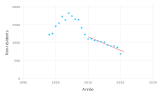

In [28]:
obs = layer(permis, x=:Année, y=:"Non-résidents", Geom.point)
model = layer(x-> B[1] + B[2] * x, 2010, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

In [29]:
Pluie2021 = PluieAn.Pluie_totale[22]
Neige2021 = NeigeAn.Neige_totale[22]
NeigeTS2021 = NeigeSolAn.Neige_totale_au_sol[22]
JPluie2021 = JourPluieAn.Jours_de_pluie[22] 
JNeige2021 = JourNeigeAn.Jours_de_neige[22]
JNeigeS2021 = JourNeigeSolAn.Jours_neige_au_sol[22] 
PrixMtl2021 = essenceMtlMoyAn.Prix_moyen_Montréal[25] 
PrixQc2021 = essenceQcMoyAn.Prix_moyen_Québec[25]
PrixEssence2021 = essenceMoyAn.Prix_moyen_Essence[25]
Temp2021

7.132786885245902

## 4. Modèles de régressions linéaires avec variables explicatives différentes pour chaque zone

In [30]:
using MLBase

function compute_VIF(structureMatrix::Array{T,2} where T<:Real)
    
    n, m = size(structureMatrix)
    
    p = m-1  # nb de variables explicatives
    
    VIF = Float64[]
    
    for j in 2:m
       
        y = structureMatrix[:,j]
        X = structureMatrix[:, setdiff(1:m, j)]
        
        β̂ = X\y
        
        e = y - X*β̂
        
        SST = sum( (y .- mean(y)).^2)
        SSE = e'e
        
        R² = 1 - SSE/SST
        
        push!(VIF, 1/(1-R²))
        
    end
    
    return VIF
    
end

compute_VIF (generic function with 1 method)

Dans cette section, nous allons tenter de créer des modèles de régression linéaire et de les ordonner du meilleur au pire selon nos prédictions

### 4.1 Modèles sans transformation de la variable d'intérêt (pas de catégorisation d'armes)

#### 4.1.1 Tenter de classer nos modèles selon le R2 (avec années et permis comme variables explicatives)

Comme première tentative, nous avons essayé de classer nos modèles selon le R2. Tel que nous allons le voir, cette méthode n'est pas optimale et nous allons utiliser une autre méthode plus loin

In [31]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Année2= Int64[], Zone = Int64[], Cerfs= Int64[], Résidents= Int64[], NonRes= Int64[], Essence= Float64[], Essence2= Float64[], Essence3= Float64[], Temperature3= Float64[], Jour_de_Pluie= Int64[], Jour_de_Pluie2= Int64[])

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)
    df = innerjoin(df, Matrice, on = :Année, makeunique=true) 
    
    df2 = DataFrame(Année = df.Année,
                    Année2 = [df.Année[i]^2 for i in 1:size(df.Année, 1)],
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs,
                    Résidents = df.Résidents,
                    NonRes = df."Non-résidents",
                    Essence = df.Prix_moyen_Essence,
                    Essence2 = [df.Prix_moyen_Essence[i]^2 for i in 1:size(df.Année, 1)], 
                    Essence3 = [df.Prix_moyen_Essence[i]^3 for i in 1:size(df.Année, 1)], 
                    Temperature3 = [df.Température[i]^3 for i in 1:size(df.Année, 1)],
                    Jour_de_Pluie = df.Jours_de_pluie,
                    Jour_de_Pluie2 = [df.Jours_de_pluie[i]^2 for i in 1:size(df.Année, 1)]) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end



sort!(new_df, :Année)
first(new_df, 5)

,Année,Année2,Zone,Cerfs,Résidents,NonRes,Essence,Essence2,Essence3,Temperature3
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1999,3996001,2,922,131325,1260,68.325,4668.31,318962.0,258.136
2,1999,3996001,3,1519,131325,1260,68.325,4668.31,318962.0,258.136
3,1999,3996001,4,4890,131325,1260,68.325,4668.31,318962.0,258.136
4,1999,3996001,5,2014,131325,1260,68.325,4668.31,318962.0,258.136
5,1999,3996001,6,4846,131325,1260,68.325,4668.31,318962.0,258.136


In [32]:
zones = unique(new_df[!, :Zone])

models = DataFrame(Zone= Int64[], R2= Float64[], Formula= Any[], Prediction= Float64[])
for i = 1:length(zones)
    modelsZone = DataFrame(R2= Float64[], Formula= Any[], Prediction= Int64[])
    
    for termes in combinations([:Année, :Essence, :Essence2, :Jour_de_Pluie, :Jour_de_Pluie2])
        formula = term(:Cerfs) ~ sum(term.(termes))
        m = lm(formula, groupby(new_df, :Zone)[i])
        pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[752], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
        push!(modelsZone, [r2(m), formula, pred])
    end
    sorted_models = sort(modelsZone, :R2, rev=true)
    
    push!(models, [groupby(new_df, :Zone)[i].Zone[1], sorted_models.R2[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
end

models

,Zone,R2,Formula
,Int64,Float64,Any
1,1,0.420667,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
2,2,0.486091,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
3,3,0.139302,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
4,4,0.328527,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
5,5,0.245412,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
6,6,0.304672,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
7,7,0.410392,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
8,8,0.383794,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2
9,9,0.450435,Cerfs ~ Année + Essence + Essence2 + Jour_de_Pluie + Jour_de_Pluie2


In [33]:
test = CSV.read("data/test.csv", DataFrame);

models = models[in.(models.Zone, Ref(test.Zone)), :]
n = size(models, 1)
prediction = DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n])

,Zone,Cerfs
,Int64,Int64
1,1,913
2,2,505
3,3,1278
4,4,2386
5,5,1767
6,6,3553
7,7,2034
8,8,2670
9,9,850


In [34]:
CSV.write("simple_regression_r2.csv", prediction)

"simple_regression_r2.csv"

Cette régression possède un rmse assez mauvais quand nous l'avons soumis sur Kaggle. Nous pouvons expliquer ceci, car nous avons utilisé le R2 comme critère de sélection de modèles. Comme nous avons vu en classe, il serait mieux d'utiliser soit directement le RMSE, ou alors de R2 ajusté, car en ce moment, on ne pénalise pas les modèles qui utilisent trop de variables explicatives (overthinking)

#### 4.1.2 Tenter de classer nos modèles selon les RMSE (avec années et permis comme variables explicatives)

Dans cette section, nous allons classer nos modèles le RMSE, en utilisant la 4e donnée dans chaque zone comme ensemble de validation

In [35]:
zones = unique(new_df[!, :Zone])

models = DataFrame(Zone= Int64[], RMSE= Float64[], Formula= Any[], Prediction= Float64[])
for i = 1:length(zones)

    modelsZone = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Float64[])

    for termes in combinations([:Année, :Année2, :Essence, :Essence2, :Résidents, :NonRes])

        train = groupby(new_df, :Zone)[i][Not(4), :]
        valid = groupby(new_df, :Zone)[i][4, :]
        
        VIF = compute_VIF(Matrix(train[:, termes]))
        
        colinéaire = 0
        
        for element in VIF
            if(element > 10)
                colinéaire = 1
            end
        end

        if (colinéaire == 0)
            try
                formula = term(:Cerfs) ~ sum(term.(termes))

                m = glm(formula, train, Normal(), IdentityLink())
                θ̂ = predict(m, DataFrame(valid))
                θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])

                rmse = StatsBase.rmsd(θ̂ , [valid.Cerfs])

                pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[130658], NonRes=[752], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
                push!(modelsZone, [rmse, formula, pred])
            catch
            end
        end
    end
    sorted_models = sort(modelsZone, :RMSE)
    
    push!(models, [groupby(new_df, :Zone)[i].Zone[1], sorted_models.RMSE[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
end

models

,Zone,RMSE,Formula,Prediction
,Int64,Float64,Any,Float64
1,1,5.0,Cerfs ~ Année,971.0
2,2,5.0,Cerfs ~ Résidents + NonRes,593.0
3,3,85.0,Cerfs ~ Essence + Essence2,1715.0
4,4,209.0,Cerfs ~ Résidents,3636.0
5,5,3.0,Cerfs ~ Année + Résidents,1823.0
6,6,11.0,Cerfs ~ Année + Année2,4228.0
7,7,332.0,Cerfs ~ Résidents,2517.0
8,8,15.0,Cerfs ~ Résidents,2841.0
9,9,47.0,Cerfs ~ Année2 + Résidents + NonRes,941.0


Comme nous pouvons voir, chaque zone possède son propre modèle, certains n'ont que l'année comme variable explicative, d'autres ont autre chose. Malheureusement, quand nous avons soumis ceci sur kaggle, nous avons obtenu un RMSE pire que le benchmark, (autour de 650). Nous allons donc tenter d'utiliser d'autres modèles

In [36]:
models = models[in.(models.Zone, Ref(test.Zone)), :]
n = size(models, 1)
prediction = DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n])

,Zone,Cerfs
,Int64,Int64
1,1,971
2,2,593
3,3,1715
4,4,3636
5,5,1823
6,6,4228
7,7,2517
8,8,2841
9,9,941


In [37]:
CSV.write("simple_regression_rmse.csv", prediction)

"simple_regression_rmse.csv"

### 4.2 Modèle avec caractérisation d'armes

Dans cette partie, nous allons tenter d'estimer, pour chaque zone, pour chaque arme, le nombre de cerfs récoltés. Toujours en utilisant le RMSE comme variable explicative

In [39]:
function get_df_engin(engin::Any)
    new_df_engin = DataFrame(Année = Int64[], Année2= Int64[], Zone = Int64[], Cerfs= Int64[], Résidents= Int64[], NonRes= Int64[],  Essence= Float64[], Essence2= Float64[], Essence3= Float64[], Temperature3= Float64[], Jour_de_Pluie= Int64[], Jour_de_Pluie2= Int64[])

    zones = groupby(recolte, :Zone)  # On groupe les données par zone
    for zone in zones  # Pour chaque zone de chasse,
        # pour chaque année,
        # on additionne le nombre de cerfs récoltés selon les différents engins de chasse.
        df_engin = combine(groupby(zone, [:Année, :Engin, :Zone]), :Cerfs => sum => :Cerfs)
        df_engin = filter(row -> row.Engin == engin,  df_engin)
        
        anneesarr = []
        zonearr = []
        cerfsarr = []
        for i in 1998:2020
            push!(anneesarr, i)
            push!(zonearr, zone.Zone[1])
            if (size(filter(row -> row.Année == i, df_engin).Cerfs, 1) == 0)
                push!(cerfsarr, 0)
            else
                push!(cerfsarr, filter(row -> row.Année == i, df_engin).Cerfs[1])
            end
        end

        df2_engin = DataFrame(Année = anneesarr, 
                        Année2 = [anneesarr[i]^2 for i in 1:size(anneesarr, 1)],
                        Zone = zonearr,
                        Cerfs = cerfsarr)
        
        df2_engin = innerjoin(df2_engin, Matrice, makeunique = true, on = :Année)
        df2_engin.NonRes = df2_engin[!, "Non-résidents"]
        df2_engin.Temperature3 = [df2_engin.Température[i]^3 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Essence = df2_engin.Prix_moyen_Essence
        df2_engin.Essence2 = [df2_engin.Prix_moyen_Essence[i]^2 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Essence3 = [df2_engin.Prix_moyen_Essence[i]^3 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Jour_de_Pluie = df2_engin.Jours_de_pluie
        df2_engin.Jour_de_Pluie2 = [df2_engin.Jours_de_pluie[i]^2 for i in 1:size(df2_engin.Année, 1)]
        df2_engin = df2_engin[!, ["Année", "Année2", "Résidents", "NonRes", "Cerfs", "Zone", "Temperature3", "Essence", "Essence2", "Essence3", "Jour_de_Pluie", "Jour_de_Pluie2"]]
        append!(new_df_engin, df2_engin)  # On ajoute l'information au DataFrame préinitialisé 
    end
    return new_df_engin
end

new_df_arc = get_df_engin("Arc")
new_df_fusil = get_df_engin("Fusil")
new_df_arbalete = get_df_engin("Arbalète")
new_df_indetermine = get_df_engin("Indéterminé")
new_df_acb = get_df_engin("ACB")
new_df_carabine = get_df_engin("Carabine")

dataframes = [new_df_arc, new_df_fusil, new_df_arbalete, new_df_acb, new_df_carabine];

In [40]:
function get_best_model(dataframe::Any)
    models = DataFrame(Zone= Int64[], RMSE= Float64[], Formula= Any[], Prediction= Float64[])
    for i = 1:length(zones) - 1

        modelsZone = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Float64[])

        for termes in combinations([:Année, :Année2, :Essence, :Résidents, :Temperature3])
            try
                formula = term(:Cerfs) ~ sum(term.(termes))

                train = groupby(new_df, :Zone)[i][Not(4), :]
                valid = groupby(new_df, :Zone)[i][4, :]

                m = glm(formula, train, Normal(), IdentityLink())
                θ̂ = predict(m, DataFrame(valid))
                θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])

                rmse = StatsBase.rmsd(θ̂ , [valid.Cerfs])
                m = glm(formula, groupby(dataframe, :Zone)[i], Normal(), IdentityLink())
                pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[130658], NonRes=[752], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
                push!(modelsZone, [rmse, formula, pred])
            catch
            end
        end
        sorted_models = sort(modelsZone, :RMSE)

        push!(models, [groupby(dataframe, :Zone)[i].Zone[1], sorted_models.RMSE[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
    end
    return models
end
predictions = []
for data in dataframes
    push!(predictions, get_best_model(data))
end
predictions

5-element Vector{Any}:
 18×4 DataFrame
 Row │ Zone   RMSE     Formula                            Prediction 
     │ Int64  Float64  Any                                Float64    
─────┼───────────────────────────────────────────────────────────────
   1 │     1      5.0  Cerfs ~ Année                             7.0
   2 │     2     21.0  Cerfs ~ Année + Temperature3              0.0
   3 │     3     79.0  Cerfs ~ Année + Année2 + Essence…        72.0
   4 │     4    209.0  Cerfs ~ Résidents                        72.0
   5 │     5      2.0  Cerfs ~ Résidents + Temperature3         36.0
   6 │     6     11.0  Cerfs ~ Année + Année2                   43.0
   7 │     7    129.0  Cerfs ~ Résidents + Temperature3        333.0
   8 │     8     15.0  Cerfs ~ Résidents                        51.0
   9 │     9    142.0  Cerfs ~ Année + Année2 + Résiden…        48.0
  10 │    10     18.0  Cerfs ~ Année + Année2 + Tempera…        11.0
  11 │    11    154.0  Cerfs ~ Année + Temperature3          

In [42]:
results = []
for models in predictions
    models = models[in.(models.Zone, Ref(test.Zone)), :]
    n = size(models, 1)
    push!(results, DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n]))
end
cerfs_recoltes = [0 for i in 1:size(results[1].Zone, 1)]
for result in results
    for i in 1:size(results[1].Zone, 1)
        cerfs_recoltes[i] = cerfs_recoltes[i] + result.Cerfs[i]
    end
end
cerfs_recoltes


17-element Vector{Int64}:
 1185
  536
 3047
 3632
 1825
 4230
 2336
 2844
 1044
 2687
  648
   25
    6
    7
 2845
  126
 1066

In [43]:
CSV.write("weapon_category_rmse_regression.csv", DataFrame(Zone = results[1].Zone, Cerfs= cerfs_recoltes))

"weapon_category_rmse_regression.csv"

En changeant la liste des variables explicatives pour n'inclure que l'année et l'année au carré, nous avons obtenu notre 3e meilleures estimations sur kaggle, avec un score de 451. Encore une fois, si on inclut les autres variables explicatives, nous obtenons des modèles qui ne sont pas mieux.

## 5. Modèles de régression multiple  globale (on utilise les mêmes variables explicatives pour toutes les zones

Pour cette section, nous nous somme demandés si c'était vraiment une bonne idée d'utiliser un modèle différent adapté pour chaque zone, ou si on essayait justement de trop apprendre de nos données, alors nous allons essayer d'utiliser les mêmes variables explicatives pour toutes les zones.

In [44]:
zones = unique(new_df[!, :Zone])

models = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Any[])
for termes in combinations([:Année, :Année2, :Jour_de_Pluie, :Jour_de_Pluie2, :Résidents, :NonRes])
    modelsCombination = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Int64[])
    formula = term(:Cerfs) ~ sum(term.(termes))
    try
        for i = 1:length(zones)


            train = groupby(new_df, :Zone)[i][Not(2), :]
            valid = groupby(new_df, :Zone)[i][2, :]

            m = glm(formula, train, Normal(), IdentityLink())
            θ̂ = predict(m, DataFrame(valid))
            θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])

            rmse = StatsBase.rmsd(θ̂ , [valid.Cerfs])

            m = glm(formula, groupby(new_df, :Zone)[i], Normal(), IdentityLink())
            pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[130658], NonRes=[752], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
            push!(modelsCombination, [rmse, groupby(new_df, :Zone)[i].Zone[1] , pred])

        end
        push!(models, [mean(modelsCombination.RMSE), formula, DataFrame(Zone= modelsCombination.Zone, Cerfs = modelsCombination.Prediction)])
    catch
    end    
end
models = sort(models, :RMSE)
best_model = models.Prediction[1]
models

,RMSE,Formula,Prediction
,Float64,Any,Any
1,295.211,Cerfs ~ Année + Année2,19×2 DataFrame
2,361.474,Cerfs ~ Année,19×2 DataFrame
3,361.579,Cerfs ~ Année2,19×2 DataFrame
4,379.895,Cerfs ~ Année + Jour_de_Pluie,19×2 DataFrame
5,379.947,Cerfs ~ Année2 + Jour_de_Pluie,19×2 DataFrame
6,400.579,Cerfs ~ Résidents + NonRes,19×2 DataFrame
7,402.316,Cerfs ~ Année + Jour_de_Pluie2,19×2 DataFrame
8,402.368,Cerfs ~ Année2 + Jour_de_Pluie2,19×2 DataFrame
9,410.263,Cerfs ~ Année + Résidents,19×2 DataFrame


Ce qui est cocace, c'est que le meilleur modèle que nous obtenons, c'est seulement le nombre de cerfs en fonction de l'année qui est le benchmark. Nous n'allons évidemment pas tester cela sur kaggle, car nous conaissons déjà le RMSE de ce modèle.

In [45]:
test = CSV.read("data/test.csv", DataFrame);

best_model = best_model[in.(best_model.Zone, Ref(test.Zone)), :]


,Zone,Cerfs
,Int64,Int64
1,1,167
2,2,503
3,3,1731
4,4,4074
5,5,2183
6,6,4228
7,7,3170
8,8,3591
9,9,872


In [46]:
CSV.write("simple_regression_same_model.csv", best_model)

"simple_regression_same_model.csv"

### 5.1.2 Utiliser le même modèle pour toutes les zones en tentant d'estimer le nombre de cerfs par arme 

In [47]:
function get_best_model(dataframes::Any)
    zones = unique(new_df[!, :Zone])

    models = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Any[])
    for termes in combinations([:Année, :Année2, :Résidents, :Essence, :Essence2, :Jour_de_Pluie, :Jour_de_Pluie2])
        try
            modelsCombination = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Float64[])
            modelsCombination_df_array = []
            formula = term(:Cerfs) ~ sum(term.(termes))
            for dataframe in dataframes
                modelsCombination_df = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Float64[])
                for i = 1:length(zones)
                    train = groupby(new_df, :Zone)[i][Not(2), :]
                    valid = groupby(new_df, :Zone)[i][2, :]

                    m = glm(formula, train, Normal(), IdentityLink())
                    θ̂ = predict(m, DataFrame(valid))
                    θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])

                    rmse = StatsBase.rmsd(θ̂ , [valid.Cerfs])
                    m = glm(formula, groupby(dataframe, :Zone)[i], Normal(), IdentityLink())
                    pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[130658], NonRes=[752], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
                    push!(modelsCombination_df, [rmse, groupby(dataframe, :Zone)[i].Zone[1] , pred])

                end
                push!(modelsCombination_df_array, modelsCombination_df)
            end
        
            zones = modelsCombination_df_array[1].Zone
            RMSE = 0
            cerfs_recoltes = [0 for i in 1:size(modelsCombination_df_array[1].Zone, 1)]
            for result in modelsCombination_df_array
                RMSE = RMSE + mean(result.RMSE)
                for i in 1:size(modelsCombination_df_array[1].Zone, 1)
                    cerfs_recoltes[i] = cerfs_recoltes[i] + result.Prediction[i]
                end
            end

            push!(models, [RMSE / 5, formula, DataFrame(Zone = modelsCombination_df_array[1].Zone, Cerfs = cerfs_recoltes)])
        catch
        end
    end
    models = sort(models, :RMSE)
    return models
end



best_model = get_best_model(dataframes).Prediction[5]
get_best_model(dataframes)

,RMSE,Formula,Prediction
,Float64,Any,Any
1,295.211,Cerfs ~ Année + Année2,19×2 DataFrame
2,353.368,Cerfs ~ Année2 + Essence2,19×2 DataFrame
3,353.474,Cerfs ~ Année + Essence2,19×2 DataFrame
4,353.842,Cerfs ~ Année2 + Essence,19×2 DataFrame
5,353.947,Cerfs ~ Année + Essence,19×2 DataFrame
6,361.474,Cerfs ~ Année,19×2 DataFrame
7,361.579,Cerfs ~ Année2,19×2 DataFrame
8,379.842,Cerfs ~ Essence + Jour_de_Pluie,19×2 DataFrame
9,379.895,Cerfs ~ Année + Jour_de_Pluie,19×2 DataFrame


Nous obtenons ici le 2e meilleurs modèles que nous avons sur kaggle, soit les cerfs en fonction de l'année, et les cerfs en fonction de l'année au carré. Encore une fois, il semblerait que l'année seule soit la meilleure combinaison de variables explicatives données.

In [48]:
test = CSV.read("data/test.csv", DataFrame);

best_model = best_model[in.(best_model.Zone, Ref(test.Zone)), :]


,Zone,Cerfs
,Int64,Int64
1,1,1640
2,2,703
3,3,1826
4,4,2720
5,5,1662
6,6,3955
7,7,3861
8,8,2944
9,9,911


In [ ]:
CSV.write("weapon_category_regression_same_model.csv", best_model)

## 6. Modèles de prédiction du nombre totale de cerfs en 2021

Comme nous l'avions découvert dans notre analyse exploratoire, les relations polynomiales de degré 2 à 4 semblaient avoir un pouvoir prédictif significatif sur le nombre de cerfs totale récolté annuellement. Construisons des modèles et sélectionnons le meilleur de prédiction. Nous utiliserons la prédiction du modèle ayant le plus petit RMSE dans notre modèle de classification pour chaque zones, soit celui qui impliquait que les cerfs récoltés suivent une loi catégorielle.


#### Ensemble d'entrainement et de validation

In [49]:
Pluie2021 = PluieAn.Pluie_totale[22]
Neige2021 = NeigeAn.Neige_totale[22]
NeigeTS2021 = NeigeSolAn.Neige_totale_au_sol[22]
JPluie2021 = JourPluieAn.Jours_de_pluie[22] 
JNeige2021 = JourNeigeAn.Jours_de_neige[22]
JNeigeS2021 = JourNeigeSolAn.Jours_neige_au_sol[22] 
PrixMtl2021 = essenceMtlMoyAn.Prix_moyen_Montréal[25] 
PrixQc2021 = essenceQcMoyAn.Prix_moyen_Québec[25]
PrixEssence2021 = essenceMoyAn.Prix_moyen_Essence[25]

152.225

In [50]:
df2021 = DataFrame(Année = 2021, Température = Temp2021, Pluie_totale = Pluie2021, Neige_totale = Neige2021, Neige_totale_au_sol = NeigeTS2021 = NeigeTS2021, Jours_de_pluie = JPluie2021,
    Jours_de_neige = JNeige2021, Jours_de_neige_au_sol = JNeigeS2021, Prix_moyen_Montréal = PrixMtl2021,
    Prix_moyen_Québec = PrixQc2021, Prix_moyen_Essence = PrixEssence2021)


,Année,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Float64,Float64,Float64,Int64,Float64
1,2021,7.13279,168.2,3.8,6,26.0


In [51]:
m = filter(row -> row.Année !== 2013, Matrice) #On retire 2013 car il nous manque les données météorologique
deers_training = filter(row -> row.Année >= 2010 && row.Année < 2020, m)
deers_validation = filter(row -> row.Année === 2020, m) #On assume que 2021 sera proche de 2001 donc on veux valider avec 2001

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2020,29661,6.64918,150.4,22.4,13,23.0


### 6.1 Modèle avec l'année

Pour ce modèles et les autres, nous utiliserons la fonction de construction de matrice polynomiales fournit lors du TD numéro 4. Celle-ci à été légèrement modifié pour ce projet.

In [52]:

function construct_structure(x::Vector{<:Any}, order::Int)
    
    X = Array{Float64}(undef, length(x), order)
    
    for p in 1:order
       X[:,p] = x.^p 
    end
    
    return X
    
end
    

construct_structure (generic function with 1 method)

Voici la fonction que nous utiliserons pour touver le meilleur ordre pour ce modèles et les autres. Celui-ci retourne le meilleur degré a utiliser pour effectuer la prédiction du nombre totale de cerfs. Celle-ci est inspirée du code fourni au TD3, soit le TD sur les modèles polynomiaux.

In [53]:
function get_best_polynomial_deers_model(variable::String, min_order::Int64, max_order::Int64)
    models = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], RMSE = Float64[], Betas = Vector{Float64}[])

    df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], RMSE = Float64[], Betas = Vector{Float64}[])

    SST = sum( (deers_training.Cerfs .- mean(deers_training.Cerfs)).^2 )

    for order in min_order:max_order
        n1 = length(deers_training.Cerfs)
        n2 = length(deers_validation.Cerfs)

        # Ajustement du modèle de régression polynomiale
        X = hcat(ones(n1), construct_structure(Vector{<:Any}(deers_training[!, variable]), order))
        β̂  = X\deers_training.Cerfs

        # Calcul de l'erreur
        ŷ = X*β̂
        e = deers_training.Cerfs - ŷ

        # Calcul de la somme du carré des erreurs
        SSE = e'e

        # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
        X̃ = hcat(ones(n2), construct_structure(deers_validation[!, variable], order))
        ỹ = X̃*β̂
        RMSE = (mean( (deers_validation.Cerfs - ỹ).^2 ))^0.5

        push!(df, [order, 1-SSE/SST, 1-(n1-1)/(n1-order-1)*SSE/SST, RMSE, β̂ ])
    end

    df = sort(df, :RMSE)
    push!(models, [df.Ordre[1], df.R[1], df.Raj[1], df.RMSE[1], df.Betas[1]])
    return  models
end

get_best_polynomial_deers_model (generic function with 1 method)

Voici la fonction qui fera une prédiction pour chaque zone. Elle prend en parametre le résultat de la fonction "get_best_polynomial_deer_model" ainsi que la donnée de 2021 qu'on utilisera pour faire notre prédiction. Elle retourne le nombre de cerfs totale qui sera récolté en 2021.

In [54]:
function polynomial_predictions(dataframe::Any, next_year_data::Any)
    
    # Matrice de la nouvelle donnée
    X = hcat(ones(1), construct_structure([next_year_data], dataframe.Ordre[1]))

    # Prédiction
    ŷ = X*dataframe.Betas[1]

    yceil = ceil(ŷ[1])

    prediction = convert(Int64, yceil)
    
    return prediction
end

polynomial_predictions (generic function with 1 method)

#### 6.1.1 Meilleur degré

In [55]:
result1 = get_best_polynomial_deers_model("Année", 1, 6)

,Ordre,R,Raj,RMSE,Betas
,Int64,Float64,Float64,Float64,Array…
1,1,0.0894467,-0.0406323,1073.2,"[6.32686e5, -299.058]"


Selon notre fonction, le meilleur degré pour estimer le nombre de cerfs en 2021 est de 1. 

#### 6.1.2 Prédiction pour 2021

In [56]:
prediction_avec_année = polynomial_predictions(result1, 2021)

28289

Sachant, que ce RMSE nous semble élevé, il se pourrait que cette prédiction ne soit pas la meilleure. Voyons voir si on peut faire mieux en ayant un plus petit RMSE.

### 6.2 Modèle avec la neige totale

#### 6.2.1 Meilleur degré

In [60]:
result2 = get_best_polynomial_deers_model("Neige_totale", 1, 6)

,Ordre,R,Raj,RMSE,Betas
,Int64,Float64,Float64,Float64,Array…
1,1,0.136144,0.0127363,145.434,"[31313.8, -80.2795]"


#### 6.2.2 Prédiction pour 2021

In [61]:
Neige2021 = NeigeAn.Neige_totale[22]
prediction_avec_neige = polynomial_predictions(result2, Neige2021)

31009

### 6.3 Modèle avec les jours de neiges

#### 6.3.1 Meilleur degré

In [63]:
result3 = get_best_polynomial_deers_model("Jours_de_neige", 1, 6)

,Ordre,R,Raj,RMSE,Betas
,Int64,Float64,Float64,Float64,Array…
1,3,0.0876276,-0.459796,637.188,"[32852.8, -1396.96, 215.095, -11.0959]"


#### 6.3.2 Prédiction pour 2021

In [64]:
JNeige2021 = JourNeigeAn.Jours_de_neige[22]
prediction_avec_jours_neige = polynomial_predictions(result3, JNeige2021)

30831

### 6.4 Modèle avec la température moyenne annuelle

#### 6.4.1 Meilleur degré

In [65]:
result4 = get_best_polynomial_deers_model("Température", 1, 8)

,Ordre,R,Raj,RMSE,Betas
,Int64,Float64,Float64,Float64,Array…
1,6,0.445649,-1.2174,67.2608,"[-2.78554e7, 3.32094e7, -1.6124e7, 4.09254e6, -5.73672e5, 42171.1, -1271.78]"


#### 6.4.2 Prédiction pour 2021

In [66]:
Temp2021 = TempMoy.Température[22]
prediction_avec_temperature = polynomial_predictions(result4, Temp2021)

34762

Comme on peut le voir, avec la température, le meilleur modèle est de degré 6, bien que cela est un peu élevé, celui donne tout de meme un bien meilleure RMSE. On constate que c'est le plus petit RMSE que nous obtenons a date, donc nous l'essayerons pour voir. Cependant, voyons si on peut obtenir un pluis petit RMSE avec les modeles de régression multiple.

### 6.5 Modèles multiples

In [67]:
deers_training = transform(deers_training, ["Jours_de_pluie"] => ByRow(x->(x)^2) => :Jours_de_pluie_square)
deers_training = transform(deers_training, ["Jours_de_pluie"] => ByRow(x->(x)^3) => :Jours_de_pluie_cubic)
deers_training = transform(deers_training, ["Jours_de_neige"] => ByRow(x->(x)^2) => :Jours_de_neige_square)
deers_training = transform(deers_training, ["Jours_de_neige"] => ByRow(x->(x)^3) => :Jours_de_neige_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2010,29738,5.42459,206.0,5.6,0,26.0
2,2011,28284,7.63607,142.6,8.2,12,22.0
3,2012,36220,5.7541,108.0,1.0,0,22.0
4,2014,31953,6.46393,120.2,17.2,19,27.0
5,2015,26458,6.10492,146.6,3.2,1,22.0
6,2016,31531,6.87541,209.4,10.0,17,26.0
7,2017,32039,6.96393,202.4,6.0,8,26.0
8,2018,29331,3.11311,154.4,44.0,58,30.0
9,2019,26091,4.28852,294.4,31.6,47,24.0


In [68]:
deers_validation = transform(deers_validation , ["Jours_de_pluie"] => ByRow(x->(x)^2) => :Jours_de_pluie_square)
deers_validation  = transform(deers_validation , ["Jours_de_pluie"] => ByRow(x->(x)^3) => :Jours_de_pluie_cubic)
deers_validation  = transform(deers_validation , ["Jours_de_neige"] => ByRow(x->(x)^2) => :Jours_de_neige_square)
deers_validation  = transform(deers_validation , ["Jours_de_neige"] => ByRow(x->(x)^3) => :Jours_de_neige_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2020,29661,6.64918,150.4,22.4,13,23.0


In [69]:
deers_training = transform(deers_training, ["Prix_moyen_Montréal"] => ByRow(x->(x)^2) => :Prix_moyen_Montréal_square)
deers_training = transform(deers_training, ["Prix_moyen_Montréal"] => ByRow(x->(x)^3) => :Prix_moyen_Montréal_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2010,29738,5.42459,206.0,5.6,0,26.0
2,2011,28284,7.63607,142.6,8.2,12,22.0
3,2012,36220,5.7541,108.0,1.0,0,22.0
4,2014,31953,6.46393,120.2,17.2,19,27.0
5,2015,26458,6.10492,146.6,3.2,1,22.0
6,2016,31531,6.87541,209.4,10.0,17,26.0
7,2017,32039,6.96393,202.4,6.0,8,26.0
8,2018,29331,3.11311,154.4,44.0,58,30.0
9,2019,26091,4.28852,294.4,31.6,47,24.0


In [70]:
deers_validation = transform(deers_validation, ["Prix_moyen_Montréal"] => ByRow(x->(x)^2) => :Prix_moyen_Montréal_square)
deers_validation = transform(deers_validation, ["Prix_moyen_Montréal"] => ByRow(x->(x)^3) => :Prix_moyen_Montréal_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2020,29661,6.64918,150.4,22.4,13,23.0


In [71]:
deers_training = transform(deers_training, ["Température"] => ByRow(x->(x)^2) => :Température_square)
deers_training  = transform(deers_training, ["Température"] => ByRow(x->(x)^3) => :Température_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2010,29738,5.42459,206.0,5.6,0,26.0
2,2011,28284,7.63607,142.6,8.2,12,22.0
3,2012,36220,5.7541,108.0,1.0,0,22.0
4,2014,31953,6.46393,120.2,17.2,19,27.0
5,2015,26458,6.10492,146.6,3.2,1,22.0
6,2016,31531,6.87541,209.4,10.0,17,26.0
7,2017,32039,6.96393,202.4,6.0,8,26.0
8,2018,29331,3.11311,154.4,44.0,58,30.0
9,2019,26091,4.28852,294.4,31.6,47,24.0


In [72]:
deers_validation = transform(deers_validation, ["Température"] => ByRow(x->(x)^2) => :Température_square)
deers_validation = transform(deers_validation, ["Température"] => ByRow(x->(x)^3) => :Température_cubic)

,Année,Cerfs,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol,Jours_de_pluie
,Int64,Int64,Float64,Float64,Float64,Int64,Float64
1,2020,29661,6.64918,150.4,22.4,13,23.0


#### 6.5.1 Meilleurs modèles de régression multiple

In [73]:

models = DataFrame(Raj = Float64[], RMSE= Float64[], Formula= Any[], Prediction= Any[])
SST = sum( (deers_training.Cerfs .- mean(deers_training.Cerfs)).^2 )
n = length(deers_training.Cerfs)
modelsCombination = DataFrame( Raj = Float64[], RMSE= Float64[], Formula = Any[], Prediction= Any[])

for termes in combinations([:Pluie_totale, :Neige_totale, :Jours_de_pluie, :Température, :Jours_de_neige, :Prix_moyen_Essence])
    formula = term(:Cerfs) ~ sum(term.(termes))
    train = deers_training
    valid = deers_validation
    p = length(termes)
    m = glm(formula, train, Normal(), IdentityLink())
    est = predict(m, DataFrame(train))
    θ̂ = predict(m, DataFrame(valid))
    θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])
    #println(est)
    rmse = StatsBase.rmsd(θ̂ , valid.Cerfs)
    e = train.Cerfs - est
    SSE = e'e
    raj =  [1-(n-1)/(n-p-1)*SSE/SST]
    if raj == 1.0
        break
    end
    
    m = glm(formula, train, Normal(), IdentityLink())
    pred = max(ceil(predict(m, DataFrame(Pluie_totale = [Pluie2021], Neige_totale = [Neige2021], Jours_de_pluie = [JPluie2021], Température = [Temp2021], Jours_de_neige = [JNeige2021], Prix_moyen_Essence = [PrixEssence2021]))[1]), 0)
    push!(modelsCombination, [raj[1], rmse, formula, DataFrame(Cerfs = pred)])
    
end
modelsCombination = sort(modelsCombination, :RMSE)

,Raj,RMSE,Formula
,Float64,Float64,Any
1,-0.00948621,126.0,Cerfs ~ Neige_totale + Jours_de_pluie + Jours_de_neige
2,0.0127363,145.0,Cerfs ~ Neige_totale
3,-0.113765,185.0,Cerfs ~ Pluie_totale + Neige_totale + Température
4,0.00447708,248.0,Cerfs ~ Jours_de_pluie + Température + Jours_de_neige
5,-0.137158,359.0,Cerfs ~ Jours_de_pluie
6,0.154524,359.0,Cerfs ~ Jours_de_pluie + Jours_de_neige
7,-0.121791,370.0,Cerfs ~ Pluie_totale + Neige_totale + Jours_de_pluie + Jours_de_neige
8,-0.142878,567.0,Cerfs ~ Neige_totale + Température
9,-0.139165,580.0,Cerfs ~ Pluie_totale + Jours_de_pluie + Température + Jours_de_neige


#### 6.5.2 Prédiction pour 2021

In [74]:
prediction_avec_multiple = modelsCombination.Prediction[1].Cerfs[1]

34245.0

Commme on peut le voir, le meilleur modele multiple nous donne un RMSE de 126 ce qui n'est pas mieux que la polynomiale de degré 6 avec la température qui donnait un RMSE de 67. De ce fait, nous pouvons assumer que c'est la prédiction avec la température que nous devrons utiliser avec nos prédictions des proportions de 2021.

Notre meilleur modèle se trouve à la section 8. Avant d'y parvenir, voyons des exemples de modèles que nous avions essayer avant d'avoir notre bon modèle de prédiction du nombre de cerfs récolté en 2021.

## 7. Modèles de prédiction des proportions de 2021 pour chaque zone


Dans cette section, nous assumerons que la probabilité qu'un cerf appartienne à une zone suit une loi catégorielle. Donc, chaque zone a une proportion teta i entre 0 et 1. Multiplier le nombre totale de cerfs par chaque proportion nous donne le nombre de cerfs de la zone.

In [75]:
df_teta = MatriceZones
first(df_teta, 5)

,Année,Cerfs_totale,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol
,Int64,Int64,Float64,Float64,Float64,Int64
1,1999,30587,6.36721,139.7,5.1,2
2,1999,30587,6.36721,139.7,5.1,2
3,1999,30587,6.36721,139.7,5.1,2
4,1999,30587,6.36721,139.7,5.1,2
5,1999,30587,6.36721,139.7,5.1,2


Comme premier modèle, nous pouvons assumer que les tendance de l'an 2021 sont exactement les mêmes que l'an passé, il nous resterait donc a estimer le nombre de cerfs total en fonction du nombre de permis non résidents.

### 7.1 Utilisation du nombre de permis pour prédire le nombre de cerfs totale en 2021

#### 7.1.1 Prédiction du nombre de cerfs récolté

In [77]:
matrice = Matrice
rename!(matrice,:"Non-résidents" => :"NonRésidents")
res=lm(@formula(Cerfs ~ NonRésidents), matrice)
rename!(matrice, :"NonRésidents" => :"Non-résidents")
deers = Int64(ceil(coef(res)[1] + coef(res)[2] * permis_non_residents_2021))

28191

#### 7.1.2 Préction du nombre de cerfs récoltés par zones

In [78]:
proportions = last(df_teta.Cerfs ./ df_teta.Cerfs_totale, 18)
preds =  [Int64(ceil(proportions[i] * deers)) for i in 1:18]

18-element Vector{Int64}:
  303
  525
 1481
 2991
 2129
 4094
 3855
 4243
 1036
 2845
  686
    9
    6
  515
 2188
  314
  837
  144

#### 7.1.3 Enregistrement des prédictions

In [79]:
test = CSV.read("data/test.csv", DataFrame);
prediction = DataFrame(Zone = test.Zone, Cerfs = preds)

CSV.write("categorielle_2020.csv", prediction)

"categorielle_2020.csv"

Cela donne un très mauvais score de 808. Trois piste sont possibles: Nous estimons mal le nombre de cerfs total, nous estimons mal le nombre de permis non résidents, et indirectement le nombre de cerfs total en 2021, ou alors les tendances de chasse de 2021 ne sont pas les mêmes qu'en 2020.

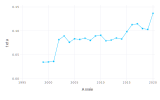

In [80]:
df_teta.teta = df_teta.Cerfs ./ df_teta.Cerfs_totale
df_teta = filter(row -> row.Zone != 21, df_teta)
plot(groupby(df_teta, :Zone)[7], x=:Année, y=:teta, Geom.point, Geom.line)

Comme on peut le voir dans le graphique plus haut, la proportion de cerfs tué dans la zone était beaucoup plus haute que d'habitude. Nous aurions probablement plus de succès si nous estimons les proportions en fonction des autres années aussi.

### 7.2 Utilisation de l'année pour prédire le nombre de cerfs totale en 2021

#### 7.2.1 Estimation des proportions pour 2021 pour chaque zone

In [106]:
teta_hat_annee = Any[]
for i in 1:18
    res=lm(@formula(teta ~ Année), groupby(df_teta, :Zone)[i])
    teta = coef(res)[1] + coef(res)[2] * 2021
    push!(teta_hat_annee, teta)
end
teta_hat_annee

18-element Vector{Any}:
 0.03318853815687989
 0.020193797601691377
 0.06096872464924097
 0.10929233438485464
 0.06382378828205093
 0.1447202901124245
 0.12138396670253115
 0.11242160453189598
 0.03225752577494001
 0.12230080438191937
 0.028781648836592844
 0.0004026988976876811
 0.00030262899081196816
 0.003997535831092469
 0.1021663434036375
 0.0052787670867989744
 0.028628673517508307
 0.005333089725003459

### 7.2.2 Prédictions pour 2021

In [107]:
preds =  [Int64(ceil(teta_hat_annee[i] * deers)) for i in 1:18]

18-element Vector{Int64}:
  936
  570
 1719
 3082
 1800
 4080
 3422
 3170
  910
 3448
  812
   12
    9
  113
 2881
  149
  808
  151

### 7.2.3 Enregistrement des prédictions

In [83]:
test = CSV.read("data/test.csv", DataFrame);
prediction = DataFrame(Zone = test.Zone, Cerfs = preds)

CSV.write("categorielle_all_years.csv", prediction)

"categorielle_all_years.csv"

Nous obtenons un rsme de 723, ce qui est une légère amélioration. Utiliser un modèles a plusieurs variables et tester les combinaisons pour chaque zone afin de trouver les meilleurs ensembles de variables aurrait peut-etre donnée de meilleurs prédictions des proportions. Il y a aussi le fait qu'utiliser un meilleurs modèle de prédiction du nombre totale de cerfs serait aussi un aspect important à la réussite de ce modèle.

C'est dailleurs avec cette idée en tete que nous avions abouti a notre meilleir modèle.

## 8. Pédictions du nombre de cers récoltés par zones : Meilleur modèle

### 8.1 Meilleure estimation du nombre de cerfs totale et proportions obtenus selon l'année

La meilleur estimation du nombre de cerfs totale en 2021 est la prédiction obtenue avec la température, c'est celui avec le plus petit RMSE. De plus, la meilleure estimation des proportions de 2021 est la pédiction obtenu en utilisant l'année sulement. De ce fait, multiplions chaque proportion par le nombre de cerfs totales récolté pour obtenir le nombre de cerfs dans chaque zone.

In [120]:
total_deers =  prediction_avec_temperature

34762

In [108]:
proportions = teta_hat_annee
preds =  [Int64(ceil(proportions[i] * total_deers)) for i in 1:18]
test = CSV.read("data/test.csv", DataFrame);
prediction = DataFrame(Zone = test.Zone, Cerfs = preds)

,Zone,Cerfs
,Int64,Int64
1,1,1154
2,2,702
3,3,2120
4,4,3800
5,5,2219
6,6,5031
7,7,4220
8,8,3908
9,9,1122


In [109]:
CSV.write("proportion_annee_cerfs_temperature.csv", prediction)

"proportion_annee_cerfs_temperature.csv"

Victoire !! Cette soumission nous a donnée 421, ce qui était notre meilleure prédiction. Du a son RMSE de 67, nous somme assez confiant de notre prédiction du nombre de cerfs totale récolté. De ce fait,pour améliorer le score de ce modèle. Il faudrait mieux prédire les proportions teta de chaque zone en 2021.

Cependant, du au temps, nous n'aurons pas l'occasion de développer un meilleur modèle.

### Modèle qu'on aurait voulu essayer :

Un modèle que nous aurions voulu essayer est celui de la régression multinomiale logistique.

En effet, dans ce modèle la zone agirait comme la variable d'intéret. Sachant que la probabilité qu'un cerfs a été récolté dans une zone est la proportion teta de celle-ci, on voit que chaque teta est bornée entre 0 et 1. Afin d'éviter d'avoir des prédictions négatives (soit un cas impossible dans la réalité), on aurrait besoins d'une fonction de lien logit pour arriver a cela. De plus, puisqu'on est dans une situation ou on a plus que 2 catégories (18 en tout) une régression logistique classique ne marcherait pas. 

On voit qu'on est donc dans une situation nécessitant un lien logit avec plus de 2 catégories, soit une situation idéale pour la régression multinomiale logistique.

Nous avions regardé en ligne pour savoir comment implémenter cela, cependant du au manque de temps et à l'apprentissage supplémentaire et nécessaire pour bien comprendre ce modèle, nous n'avons pas eu le temps de l'exécuter.

## Quelques tentatives supplémentaires

Lors de ce projets, nous avions essayé d'autres modèles qui non malheuresement pas porté fruit. Les voici:

## 9. Modèles de régression Ridge

### 9.1 Modèle de régression simple avec l'année

In [90]:
MatriceZones = filter(row -> row.Zone !== 21, MatriceZones)

,Année,Cerfs_totale,Température,Pluie_totale,Neige_totale,Neige_totale_au_sol
,Int64,Int64,Float64,Float64,Float64,Int64
1,1999,30587,6.36721,139.7,5.1,2
2,1999,30587,6.36721,139.7,5.1,2
3,1999,30587,6.36721,139.7,5.1,2
4,1999,30587,6.36721,139.7,5.1,2
5,1999,30587,6.36721,139.7,5.1,2
6,1999,30587,6.36721,139.7,5.1,2
7,1999,30587,6.36721,139.7,5.1,2
8,1999,30587,6.36721,139.7,5.1,2
9,1999,30587,6.36721,139.7,5.1,2


#### 9.1.1 Séparation des données en zones pour ensuite normalisé chaque zone 

In [91]:
sigmas = Array{Float64}(undef, 18) 
deer_sigmas = Array{Float64}(undef, 18)  
mus = Array{Float64}(undef, 18) 
deer_mus = Array{Float64}(undef, 18) 
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(MatriceZones[!, [:Année, :Zone ,:Cerfs]]), dims=1)
norm_zone = DataFrame()
for i in 1:18
    new = Matrix{Float64}(groupby(MatriceZones[!, [:Année, :Zone ,:Cerfs]], :Zone)[i])
    norm_zone = vcat(norm_zone, DataFrame(StatsBase.transform(dt, Matrix{Float64}(groupby(MatriceZones[!, [:Année, :Zone, :Cerfs]], :Zone)[i])), [:Année, :Zone, :Cerfs]))
    sigmas[i] = std(new[:, 1])
    deer_sigmas[i] = std(new[:, 3])
    mus[i] = mean(new[:, 1])
    deer_mus[i] = mean(new[:, 3])

end


#### 9.1.2 Création d'une partition de validation et d'entrainement

In [92]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(norm_zone))

train_id = sample(1:nrow(norm_zone), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(norm_zone), train_id)

training = norm_zone[train_id, :]
validation = norm_zone[valid_id, :]

,Année,Zone,Cerfs
,Float64,Float64,Float64
1,-1.46112,-1.25686,-0.698283
2,-0.65264,-1.25686,0.00383352
3,0.317537,-1.25686,-0.264844
4,-1.29942,-1.121,-0.496371
5,-1.13773,-1.121,-0.590596
6,-0.976032,-1.121,-0.342379
7,-0.490944,-1.121,-0.533522
8,0.155841,-1.121,-0.775279
9,1.12602,-1.121,-0.6579


#### 9.1.3 Régression Ridge avec l'année

In [93]:
true_betas = Array{Float64}(undef, 18) 
for i in 1:18

    normalized_data = Matrix{Float64}(groupby(training, :Zone)[i])
    X = normalized_data[:,Not([2,3])]
    y = normalized_data[:,3]

    n = length(y)
    m = size(X,2)

    norm_data = Matrix{Float64}(groupby(validation, :Zone)[i])
    
    true_X = norm_data[:,Not([2,3])]
    true_Y = norm_data[:,3]
    previous_rmse = 10000
    lamda_hat = 0
    for λ = 0:0.01:10
        β̂ = (X'X + λ*I)\X'y  
        
        ŷ = true_X*β̂  
        
        rmse = StatsBase.rmsd(ŷ, true_Y)  
        if previous_rmse > rmse
            lamda_hat = λ 
            previous_rmse = rmse
        else
            break
        end
    end 
   

    betas_hat = (X'X + I*lamda_hat)\X'y; 
    ŷ = X*betas_hat 
    e = y-ŷ  
    σ̂² = sum((y.-ŷ).^2)/n
    Σ = σ̂²*inv(X'X + lamda_hat*I)  

    pd = LocationScale(betas_hat[1], sqrt(Σ[1,1]), TDist(n-m)) 

    f₁(σ²::Real) = MvNormal(betas_hat, σ²*inv(X'X + lamda_hat*I))
    
    f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*lamda_hat*β'β) 


    niter = 1000 

    β = Array{Float64}(undef, 1, niter)  
    σ² = Array{Float64}(undef, niter)

    β[:,1] = zeros(1)
    σ²[1] = 0.005;
    
    for j in 2:niter   
        β[:,j] = rand(f₁(σ²[j-1]))    
        σ²[j] = rand(f₂(β[:,j]))      
    end
   
    β = β[101:end]
    σ² = σ²[101:end];
    true_betas[i] = mean(β[:])
end
true_betas

18-element Vector{Float64}:
 -0.09252326387502874
 -0.06202278579504693
 -0.024725903508651163
 -0.2060101079892628
  0.0037980933213174854
 -0.2637655645510532
  0.1455525934075847
  0.006494536305097995
 -0.07082930129794164
 -0.6054415835162036
 -0.08960153214419814
 -0.2003283843452469
  0.048391844525635254
 -0.08256612357691659
 -0.3975065840790086
 -0.22725462025600984
 -0.1607353009846662
 -0.7278776495109782

In [94]:
test = CSV.read("data/test.csv", DataFrame);
ŷ = [Int64(ceil((((2021 - mus[i])/sigmas[i])*true_betas[i]) * deer_sigmas[i] + deer_mus[i])) for i in 1:18];#
ŷ

18-element Vector{Int64}:
 1031
  824
 1785
 3423
 1834
 4283
 2968
 2840
 1286
 3735
 1244
   13
    8
  190
 3787
   50
  550
   19

#### 9.1.4 Sauvegarde du modèle

In [95]:
prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("regression_Ridge_Annee.csv", prediction)

"regression_Ridge_Annee.csv"

Nous avons eu un meilleur score que le benchmark, mais de peu. Nous avons eu 598 au lieu de 603.

### 9.2 Regression ridge pour le type d'armes

Au moment où ce code a été écrit, notre meilleur score était de 451, en faisant une régression linéaire simple des cerfs en fonction des années pour chaque armes. Nous verrons donc si nous pouvons améliorer ce score en faisant une régression ridge.

#### 9.2.1 Séparation des données selon l'arme

In [97]:
new_df_arc = get_df_engin("Arc")
new_df_fusil = get_df_engin("Fusil")
new_df_arbalete = get_df_engin("Arbalète")
new_df_indetermine = get_df_engin("Indéterminé")
new_df_acb = get_df_engin("ACB")
new_df_carabine = get_df_engin("Carabine")

dataframes = [new_df_arc, new_df_fusil, new_df_arbalete, new_df_indetermine, new_df_acb, new_df_carabine];
for i in 1:6
    dataframes[i] = filter(row -> row.Zone != 21, dataframes[i])
end

#### 9.2.1 création d'une partition de validation et d'entrainement

In [98]:
norm_zones = Any[]
training = Any[]
validation = Any[]
sigmas = Array{Float64}(undef, 6, 18) 
deer_sigmas = Array{Float64}(undef, 6, 18)
mus = Array{Float64}(undef, 6, 18)
deer_mus = Array{Float64}(undef, 6, 18)
for i in 1:6
    norm_zone = DataFrame()
    dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(dataframes[i][!, [:Année, :Zone, :Cerfs]]), dims=1)
    for j in 1:18
        new = Matrix{Float64}(groupby(dataframes[i][!, [:Année, :Zone, :Cerfs]], :Zone)[j])
        norm_zone = vcat(norm_zone, DataFrame(StatsBase.transform(dt, Matrix{Float64}(groupby(dataframes[i][!, [:Année, :Zone, :Cerfs]], :Zone)[j])), [:Année, :Zone, :Cerfs]))
        sigmas[i, j] = std(new[:, 1])
        deer_sigmas[i, j] = std(new[:, 3])
        mus[i, j] = mean(new[:, 1])
        deer_mus[i, j] = mean(new[:, 3])
    end
    push!(norm_zones, norm_zone)
    Random.seed!(3302)

    ntrain = round(Int, .75*nrow(norm_zone))

    train_id = sample(1:nrow(norm_zone), ntrain, replace=false, ordered=true)
    valid_id = setdiff(1:nrow(norm_zone), train_id)

    push!(training, norm_zone[train_id, :])
    push!(validation, norm_zone[valid_id, :])
end
groupby(training[6], :Zone)[18]

,Année,Zone,Cerfs
,Float64,Float64,Float64
1,-1.65294,1.97552,-0.796108
2,-1.33809,1.97552,-0.796108
3,-1.18067,1.97552,-0.796108
4,-0.865826,1.97552,-0.796108
5,-0.708403,1.97552,-0.796108
6,-0.55098,1.97552,-0.796108
7,-0.393557,1.97552,-0.796108
8,-0.236134,1.97552,-0.796108
9,-0.0787115,1.97552,-0.796108


#### 9.2.2 estimation des betas

In [99]:
all_weapons_betas = Any[]
for j in 1:6
    true_betas = Array{Float64}(undef, 18) 
    for i in 1:18
        #groupby(training, :Zone)[i]
        normalized_data = Matrix{Float64}(groupby(training[j], :Zone)[i])
        X = normalized_data[:,Not([2,3])]
        y = normalized_data[:,3]

        n = length(y)
        m = size(X,2)

        norm_data = Matrix{Float64}(groupby(validation[j], :Zone)[i])
        #Not([1, 3, 4])
        true_X = norm_data[:,Not([2,3])]
        true_Y = norm_data[:,3]
        previous_rmse = 10000
        lamda_hat = 0
        for λ = 0:0.01:10
            β̂ = (X'X + λ*I)\X'y  # on fait la régression pour trouver les coefs.
            
            ŷ = true_X*β̂  # on fait une prédiction (comme avant) avec les données de test
            
            rmse = StatsBase.rmsd(ŷ, true_Y)  # on calcul le rmse (avec StatsBase...)
            if previous_rmse > rmse
                lamda_hat = λ 
                previous_rmse = rmse
            else
                break
            end
        end 
        # println(lamda_hat)
        # println(previous_rmse)

        betas_hat = (X'X + I*lamda_hat)\X'y; 
        ŷ = X*betas_hat # donc on fait une prédiction
        e = y-ŷ  # puis on calcule l'erreur
        σ̂² = sum((y.-ŷ).^2)/n
        Σ = σ̂²*inv(X'X + lamda_hat*I)  # on calcule la matrice Σ

        pd = LocationScale(betas_hat[1], sqrt(Σ[1,1]), TDist(n-m))  # on crée l'objet de type loi de student multidim à ν ddl

        # ici, la fonction LocationScale() permet de rajouter un param. de localisation μ et un param. d'échelle Σ
        # à la loi TDist(n-m)
        # Ici je suis allé chercher les équations 7.12 et 7.13 du chap. 7
        # Loi cond. de β
        f₁(σ²::Real) = MvNormal(betas_hat, σ²*inv(X'X + lamda_hat*I))
        #f₁(σ²::Real) = MvNormal(betas_hat, σ²*Symmetric(inv(X'X + lamda_hat*I))) # MvNormal = multivariate normal (multi dim!)
        # Ici, inv(X'X + λ̂*I) est déjà symétrique mais on a besoin de Symmetric à cause des petits différences numériques 

        # Loi cond. de σ²
        f₂(β::Vector{<:Real}) = InverseGamma((n+m)/2, .5(y-X*β)'*(y-X*β) + .5*lamda_hat*β'β) 


        ### Échantillonage de Gibbs
        niter = 1000 

        # Initialisation des arrays pour β et σ²
        β = Array{Float64}(undef, 1, niter)  
        σ² = Array{Float64}(undef, niter)

        # Définition des conditions de départ pour Gibbs
        β[:,1] = zeros(1)
        σ²[1] = 0.005;
        # Boucle de 2 à 1000
        for j in 2:niter   
            β[:,j] = rand(f₁(σ²[j-1]))    # on tire une valeur pour β à partir de σ² de l'itération j-1
            σ²[j] = rand(f₂(β[:,j]))      # on tire une valeur pour σ² à partir de β de l'itération j
        end
        # Retrait des itérations de chauffe (j'aurais aussi pu utiliser deleteat!(β, 1:100) sinon)
        β = β[101:end]
        σ² = σ²[101:end];
        true_betas[i] = mean(β[:])
        # plot(
        #     layer(x->pdf(pd,x), -.5, .5, Theme(default_color=colorant"red"),  # le layer pour la densité
        #             # ↑ évalue la densité de probabilité de pd, entre -.5 et .5
        #     xintercept = quantile.(pd, [.025, .975]), Geom.vline(style=:dash, color="red")),  # les lignes pointillés (intervalles)
        #     Guide.xlabel("β₁"), Guide.ylabel("Densité"),
            
        #     layer(x=β[:], Geom.histogram(density=true, bincount=30)) # le layer pour l'histogramme (densité=true pour l'échelle)
        # ) 
    end
    push!(all_weapons_betas, true_betas)
end
all_weapons_betas[1]

18-element Vector{Float64}:
 -0.028096908803306647
 -0.0988159389838586
 -0.1986489214301053
 -0.49768052730518686
 -0.17263819515255363
 -0.42821172243657873
 -2.431887110723828
 -0.29543989033934104
 -0.27138857781195785
 -0.5298738728941358
 -0.1217256760750609
 -0.05039042920874158
 -0.035197073104394926
  0.02418297879206506
 -0.1004855353253863
 -0.01188748100923523
 -0.015755414369931896
  0.05581462484762429

In [100]:
test = CSV.read("data/test.csv", DataFrame);
ŷ = Int64[]
for i in 1:18
    sum = 0
    for j in 1:6
        sum += (((2021 - mus[j, i])/sigmas[j, i])*all_weapons_betas[j][i]) * deer_sigmas[j, i] + deer_mus[j, i]
    end
    push!(ŷ, ceil(sum))
end
ŷ

18-element Vector{Int64}:
 1040
  807
 1848
 3939
 1829
 4514
 2794
 2911
 1263
 4152
 1229
   12
    7
  224
 3492
   66
  689
   20

#### 9.2.3 Enregistrement des prédictions

In [101]:
prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("regression_Ridge_Armes.csv", prediction)

"regression_Ridge_Armes.csv"

Nous obtenons un rmse de 533 avec cet échantillon, ce qui est pire qu'avec la régression classique. Visiblement, les données ne possèdent pas assez de multicolinéarité pour qu'il vaille la peine d'introduire un billet.

## 10. Modèles sans régression

### 10.1 Espérance de chaque zone

Pour nos deux premiers estimateurs, nous avons testé la moyenne et la médiane de chaque zone. Ce sont donc des estimateurs très naïfs

In [121]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(new_df, :Année)

zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone.Cerfs
        push!(ŷ,ceil(mean(y)))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("mean.csv", prediction);

### 10.2 Médiane de chaque zone

In [122]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone.Cerfs
        push!(ŷ,ceil(median(y)))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("mediane.csv", prediction);

### 10.3 Recherche de la loi qui distribue les cerfs

Pour cette partie, nous allons insinuer que le nombre de cerfs distribués est une variable aléatoire distribué selon une loi quelconque pour chaque zone, traçons donc l'histogramme de cerfs récoltés pour chaque zone

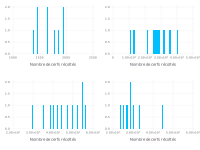

In [123]:
zones = unique(new_df[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Cerfs, Geom.histogram(bincount=100), Guide.xlabel("Nombre de cerfs récoltés"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[5:8], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

> Comme nous pouvons le voir, le nombre de cerfs résoltés semble, à première vue, suivre une loi uniforme, avec le maximum et le minimum de chaque zone comme bornes a et b. Pour calculer le nombre de cerfs effectués, nous pouvons utiliser plusieurs estimateurs, soit un estimateur naïf, l'espérence et un estimateur bayésien.

#### 10.3.1 Estimateur loi uniforme

Comme nous avons vu, l'espérence (ainsi que la médiane) d'une loi uniforme se calcule selon la formule suivante

> (a + b) / 2

Ou a et b sont les bornes supérieures et inférieures du modèle

In [ ]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);
ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone[!, :Cerfs]
        a = -1
        b = -1
        for qte in y
            if (a == -1 || qte < a)
                a = qte
            end
            if (b == -1 || qte > b)
                b = qte
            end
        end
        push!(ŷ,ceil((a + b) / 2))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("loi_uniforme_moyenne_naive.csv", prediction);

Le résultat sur Kaggle pour ce modèle n'est pas très bon, il est plus bas que le benchmark

Pour tenter d'expliquer cela, nous avons tracé les histogrames avec des colonnes plus larges, et avons effectivement remarqué que le nombre de cerfs récoltés ne semble pas suivre de loi particulière, ni même de mélange de lois

In [ ]:
zones = unique(new_df[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Cerfs, Geom.histogram(bincount=7), Guide.xlabel("Nombre de cerfs récoltés"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[5:8], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 10.3.2 Tenter de modifier la variable d'intérêt

Finalement, comme dernière tentative, nous allons tenter de modifier la variable d'intérêt pour essayer de trouver une loi quelconque

In [ ]:
common = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[], Prix = Float64[])
common = leftjoin(new_df, permis, on = :Année)

zones = unique(common[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    temp_df = groupby(common, :Zone)[i]
    n = size(temp_df,1)
    temp_df.new_ve = [temp_df[i, :Cerfs] / temp_df[i, :"Total"] for i in 1:n]
    p = plot(temp_df, x="new_ve", Geom.histogram(bincount=10), Guide.xlabel("Cerf récolté par permis émis"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

Comme on peut voir, le nombre de cerfs récoltés par permis émis semble suivre grossièrement une loi normale pour la plupart des zones. On peut donc tenter d'estimer cette valeur pour l'année 2021 en tenter d'estimer le nombre de permis émis en 2021

In [ ]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for i = 1:length(zones)
    if (groupby(common, :Zone)[i][!, "Zone"][1] != 21)
        temp_df = groupby(common, :Zone)[i]
        n = size(temp_df,1)
        temp_df.new_ve = [temp_df[i, :Cerfs] / temp_df[i, :"Total"] for i in 1:n]
        y = temp_df.new_ve
        push!(ŷ,ceil(mean(y) * 128618.0))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("variable_explicative_transformée.csv", prediction);